# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer, r2_score
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# 1. Import Data

In [2]:
import pandas as pd

df_qt = pd.read_csv('/kaggle/input/qt-public.csv')
df_tbtl = pd.read_excel('/kaggle/input/tbtl-public.ods', engine='odf')
df_th = pd.read_csv('/kaggle/input/th-public.csv')
df_ck = pd.read_csv('/kaggle/input/ck-public.csv')
df = pd.read_csv("/kaggle/input/annonimized.csv")

In [3]:
print(df_qt.sample(5))
print(df_tbtl.sample(5))
print(df_th.sample(5))
print(df_ck.sample(5))
print(df.sample(5))
print(df.info())

                                         hash diemqt
549  5eecd9dc3fe216cd45a2194e5f1a1d472a3fec56      9
538  5e092e334855a0d8739d53c39798bb26f3376959     10
47   073de6e606b6b7f3f44a8e8301ee87c3c978a2e2      7
4    014c59c6433fd764a0b08de6ffeb757eaf60aa73      9
79   0c9cad573ea42e5a8d9058b834cbc9255128d54b     10
                                     username  TBTL
92   0e346c62a6706465a1c49c59224eed1cdb5f7f5c  8.43
432  491ae8a65839fc737fb2c3e6ed06b990c7f36dea  8.32
10   020ef1c31cb4751bbfa1a88fba782db3c402e2fa  7.41
190  1e59ca9160cbe32a3bebef6df4339e30a16d0dfd  6.98
454  4cc8a421bf0c776aae86c3838ed759171d4cee50  8.37
                                         hash   TH
625  6c468e0d90bf790fd74609738544edd3f0e5c74c    8
374  4069b40bebe0372926fcd92429f7431e300e6b52    9
401  4586b41a1f104874583010a544bdd65113d2666c   10
313  34ffbe3d2820a74472b93e9dcabc0e17f75e779c  7.5
561  616bff7fefe77a5e5618f600b39cc1002b71867c   10
                                         hash   CK
323  37472566

# 2. Preprocessing

In [4]:
#Taọ dataframe copy để dễ xử lý
df_cp = df.copy()

# Đổi tên các cột để dễ sử dụng
df_cp['problem_id'] = df["concat('it001',`problem_id`)"]
df_cp['username'] = df["concat('it001', username)"]
df_cp['assignment_id'] = df["concat('it001',`assignment_id`)"]

In [5]:
df_cp['created_at'] = pd.to_datetime('2020-' + df_cp['created_at'], format='%Y-%m-%d %H:%M:%S')
df_cp['updated_at'] = pd.to_datetime('2020-' + df_cp['updated_at'], format='%Y-%m-%d %H:%M:%S')

# Trích xuất số tuần và ngày trong tuần từ 'updated_at'
df_cp['week_number'] = df_cp['updated_at'].dt.isocalendar().week
df_cp['day_of_week'] = df_cp['updated_at'].dt.dayofweek

In [6]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295198 entries, 0 to 295197
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   concat('it001',`assignment_id`)  295198 non-null  object        
 1   concat('it001',`problem_id`)     295198 non-null  object        
 2   concat('it001', username)        295198 non-null  object        
 3   is_final                         295198 non-null  int64         
 4   status                           295198 non-null  object        
 5   pre_score                        295198 non-null  int64         
 6   coefficient                      295198 non-null  int64         
 7   concat('it001',`language_id`)    295198 non-null  object        
 8   created_at                       295198 non-null  datetime64[ns]
 9   updated_at                       295198 non-null  datetime64[ns]
 10  judgement                        295198 non-

# 3. Feature Engineering

### 3.1 Thống kê tổng problems, assignments

In [7]:
def get_total_problems_assignments(df: pd.DataFrame) -> dict:
    """ Hàm thống kê tổng số problems, tổng số assignments

    Args:
        df (pd.DataFrame): Assignment DataFrame

    Returns:
        dict: Series Total problems, Total assignments 
    """

    total_problems = df.groupby('username')['problem_id'].nunique()
    total_assignments = df.groupby('username')['assignment_id'].nunique()

    return {'total_problems' : total_problems, 
            'total_assignments' : total_assignments}


### 3.2 Thống kê tỉ lệ nộp bài

In [8]:
def get_rate_submission_correct(df: pd.DataFrame) -> dict:
    """Hàm thống kê tỉ lệ làm bài đúng sớm, đúng trễ, chưa hoàn thành

    Args:
        df (pd.DataFrame): Assignment DataFrame

    Returns:
        dict: Series Rate early correct, Rate late correct, not completed
    """    

    total_problems = get_total_problems_assignments(df)['total_problems']
    
    early_correct_rate = df[(df['pre_score'] == 10000) & (df['coefficient'] == 100)].groupby('username')['problem_id'].nunique() / total_problems
    early_correct_rate.fillna(0, inplace=True)


    not_completed_rate = 1 - early_correct_rate

    return {'early_correct_rate': early_correct_rate,
            'not_completed_rate': not_completed_rate}


### 3.3 Thống kê tỉ lệ nộp bài thành công, thất bại

In [9]:
def get_successful_unsuccessful_submissions_rate(df: pd.DataFrame) -> dict:
    """Thống kê tỉ lệ nộp bài thành công

    Args:
        df (pd.DataFrame): Assignment DataFrame

    Returns:
        dict: Series Successful, unsuccessful submission avg
    """

    successful_submissions = df[df['pre_score'] == 10000].groupby('username').size()
    unsuccessful_submissions = df[df['pre_score'] < 10000].groupby('username').size()
    successful_rate_avg = successful_submissions / (successful_submissions + unsuccessful_submissions)
    unsuccessful_rate_avg = unsuccessful_submissions / (successful_submissions + unsuccessful_submissions)

    successful_rate_avg.fillna(0, inplace=True)
    unsuccessful_rate_avg.fillna(0, inplace=True)

    return {'successful_rate_avg': successful_rate_avg,
            'unsuccessful_rate_avg': unsuccessful_rate_avg}

### 3.4 Thống kê tỉ lệ lỗi 

In [10]:
def get_error_info(df: pd.DataFrame) -> dict:
    """Thống kê số lượng và tỉ lệ các lõi của submission

    Args:
        df (pd.DataFrame): Assignment DataFrame

    Returns:
        dict: Dict: Serise group err: Limit_Exceeded, Run_Time_Error, Wrong, Banned
    """

    # Các nhóm loại lỗi
    err_groups = {
        "Limit_Exceeded": ["Time Limit Exceeded", "Memory Limit Exceeded"],
        "Run_Time_Error": ["was not declared in this scope", "invalid type", "expected declaration"],
        "Wrong": ["WRONG"],
        "Banned": ["is banned"]
    }
     
    err_count = dict()

    total_assignments = get_total_problems_assignments(df)['total_assignments']

    # Tính toán số lượng đánh giá
    for err_group, err_strs in err_groups.items():
        err_count[err_group] = df['judgement'].apply(lambda judge: 
                                                        any(err_str in judge for err_str in err_strs)).groupby(df['username']).sum()
        err_count[err_group + '_avg'] = err_count[err_group] / total_assignments

    return err_count
    

### 3.5 Thống kê bài tập khó, dễ, trung bình

In [11]:
def get_difficulty_mapping(df: pd.DataFrame, easy_per: float = 0.7, difficult_per: float = 0.3)-> dict:
    """Tạo mapping độ khó dễ trung bình cho problem dựa voà số sinh viên hoàn thành problem

    Args:
        df (pd.DataFrame): Assignment DataFrame
    Returns:
        dict: dict map problem to difficulty
    """

    # Tính toán tỉ lệ hoàn thành bài
    completed_problems = df_cp[df_cp['pre_score'] == 10000].groupby('problem_id')['username'].nunique().reset_index()
    completed_problems.columns = ['problem_id', 'num_completed']

    # Tính tổng số lượng người dùng đã nộp bài cho từng bài
    total_submissions = df_cp.groupby('problem_id')['username'].nunique().reset_index()
    total_submissions.columns = ['problem_id', 'num_submissions']

    # Tính toán tỉ lệ hoàn thành bài và điền giá trị NaN bằng 0
    problem_completion_rate = pd.merge(total_submissions, completed_problems, on='problem_id', how='left')
    problem_completion_rate['completion_rate'] = problem_completion_rate['num_completed'] / problem_completion_rate['num_submissions']
    problem_completion_rate['completion_rate'] = problem_completion_rate['completion_rate'].fillna(0)

    # Xác định ngưỡng cho các bài dễ, trung bình và khó
    thresholds = problem_completion_rate['completion_rate'].quantile([difficult_per, easy_per])
    problem_completion_rate['difficulty'] = pd.cut(problem_completion_rate['completion_rate'],
                                                bins=[-1, thresholds.iloc[0], thresholds.iloc[1], 1],
                                                labels=['difficult', 'medium', 'easy'])

    # # Gán mức độ khó cho các bài
    difficulty_mapping = problem_completion_rate.set_index('problem_id')['difficulty']

    return difficulty_mapping

In [12]:
def get_problems_solve(df: pd.DataFrame)-> dict:
    """Thống kê tỉ lệ bài tập sinh viên giải và giải được theo từng độ khó

    Args:
        df (pd.DataFrame): Assigment DataFrame

    Returns:
        dict: _description_
    """

    # Tính toán số lượng bài theo độ khó cho từng sinh viên
    student_problem_counts = df_cp.groupby(['username', 'difficulty'])['problem_id'].nunique().unstack(fill_value=0)

    # Tính tổng số bài cho từng sinh viên
    student_problem_counts['total'] = student_problem_counts.sum(axis=1)

    # Tính tỉ lệ cho từng mức độ khó (dễ, trung bình, khó)
    student_problem_counts['difficult_rate'] = student_problem_counts['difficult'] / student_problem_counts['total']
    student_problem_counts['medium_rate'] = student_problem_counts['medium'] / student_problem_counts['total']
    student_problem_counts['easy_rate'] = student_problem_counts['easy'] / student_problem_counts['total']

    return student_problem_counts

def get_problems_finished(df: pd.DataFrame)-> dict:
    """Thống kê tỉ lệ problem sinh viên hoàn thành 

    Args:
        df (pd.DataFrame): _description_

    Returns:
        dict: _description_
    """
    student_problem_counts = get_problems_solve(df)

    # Tính toán số lượng bài khó đã giải được cho từng học sinh (có pre_score = 10000)
    student_problem_solved_counts = df_cp[df_cp['pre_score'] == 10000].groupby(['username', 'difficulty'])['problem_id'].nunique().unstack(fill_value=0)

    # Tính tổng số bài khó đã giải được cho từng học sinh
    student_problem_solved_counts['total_solved'] = student_problem_solved_counts.sum(axis=1)

    # Tính tỉ lệ hoàn thành bài khó, trung bình và dễ
    student_problem_solved_counts['difficult_finished_rate'] = student_problem_solved_counts['difficult'] / student_problem_counts.loc[:, 'difficult']
    student_problem_solved_counts['medium_finished_rate'] = student_problem_solved_counts['medium'] / student_problem_counts.loc[:, 'medium']
    student_problem_solved_counts['easy_finished_rate'] = student_problem_solved_counts['easy'] / student_problem_counts.loc[:, 'easy']

    return student_problem_solved_counts

### 3.6 Thống kê số submission nộp trung bình mỗi problem

In [13]:
def get_avg_submission_per_assignments(df: pd.DataFrame)-> pd.DataFrame:
    """_summary_

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    # Tính tổng số lần nộp bài của mỗi sinh viên
    total_submissions = df.groupby('username')['problem_id'].count()

    # Tính tổng số assignment của mỗi sinh viên
    total_assignments = df.groupby('username')['assignment_id'].nunique()

    # Chia tổng số lần nộp bài cho tổng số assignment để tính trung bình
    average_submissions_per_assignment = total_submissions / total_assignments

    # Tạo DataFrame để lưu kết quả
    df_average_submissions = average_submissions_per_assignment.reset_index()
    df_average_submissions.columns = ['username', 'avg_submissions_per_assignment']

    # Điền các giá trị NaN bằng 0 (nếu có)
    df_average_submissions['avg_submissions_per_assignment'].fillna(0, inplace=True)

    return df_average_submissions

## 3.7. Thống kê cột created_at

In [14]:
def get_avg_solved_submissions_per_week(df: pd.DataFrame)-> pd.DataFrame:
    """_summary_

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    # Lọc các bài tập đã được giải (pre_score = 10000)
    solved_problems = df[df['pre_score'] == 10000]

    # Tính tổng số bài tập được giải cho mỗi sinh viên theo tuần
    weekly_solved_submissions = solved_problems.groupby(['username', 'week_number'])['problem_id'].count().reset_index(name='weekly_solved_count')

    # Tính trung bình số bài tập được giải mỗi tuần của mỗi sinh viên
    average_weekly_solved_submissions = weekly_solved_submissions.groupby('username')['weekly_solved_count'].mean().reset_index(name='average_solved_submissions_per_week')

    return average_weekly_solved_submissions
    

def get_avg_submission_per_week(df: pd.DataFrame)-> pd.DataFrame:
    """_summary_

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """

    # Tính tổng số bài tập được giải cho mỗi sinh viên theo tuần
    weekly_submissions = df.groupby(['username', 'week_number'])['problem_id'].count().reset_index(name='weekly_count')

    # Tính trung bình số bài tập được giải mỗi tuần của mỗi sinh viên
    average_weekly_solved_submissions = weekly_submissions.groupby('username')['weekly_count'].mean().reset_index(name='avg_submissions_per_week')

    return average_weekly_solved_submissions


## 3.8. Thống kê số submission khó trung bình

In [15]:
def get_submission_difficult(df: pd.DataFrame)-> pd.DataFrame:
    """_summary_

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    
    average_submissions_difficult = df[df['difficulty'] == 'difficult'].groupby('username').size() / df[df['difficulty'] == 'difficult'].groupby('username')['problem_id'].nunique()
    average_submissions_difficult = average_submissions_difficult.reset_index(name='avg_submissions_difficult')
    average_submissions_difficult.fillna(0, inplace=True)

    return average_submissions_difficult

## 3.9. Thêm đặc trưng vào DataFrame dựa vào DataFrame cũ

In [16]:
# Tạo DataFrame df_statistics để thiết kế đặc trưng
df_statistics = pd.DataFrame()

#Thêm cột tổng số problems & tổng số assignments
df_statistics[['total_problems', 'total_assignments']] = pd.DataFrame(get_total_problems_assignments(df_cp))

#Thêm cột tỉ lệ problem làm đúng sớm, đúng trễ, chưa hoàn thành
df_statistics[['rate_early_correct', 'not_completed']] = pd.DataFrame(get_rate_submission_correct(df_cp))

#Thêm cột tỉ lệ nộp bài thành công, thất bại
df_statistics[['sucessful_rate_avg', 'unsucessful_rate_avg']] = pd.DataFrame(get_successful_unsuccessful_submissions_rate(df_cp))

#Thêm các cột số lượng lỗi và trung bình lỗi trong assignments
err_info_dict = get_error_info(df_cp)
columns = list(err_info_dict.keys())
df_statistics[columns] = pd.DataFrame(err_info_dict)

#Thêm cột phân loại problem khó dễ trung bình vào df_cp
difficulty_mapping = get_difficulty_mapping(df_cp, 0.65, 0.3)
df_cp['difficulty'] = df_cp['problem_id'].map(difficulty_mapping)

#Thêm cột thống kê tỉ lệ problem đã giải dựa vào độ khó
student_problem_counts = get_problems_solve(df_cp)
student_problem_finished = get_problems_finished(df_cp)
df_statistics = df_statistics.merge(student_problem_counts[['difficult_rate', 'easy_rate', 'medium_rate']], left_index=True, right_index=True, how='left')
df_statistics = df_statistics.merge(student_problem_finished[['difficult_finished_rate', 'easy_finished_rate', 'medium_finished_rate']], left_index=True, right_index=True, how='left')
df_statistics = df_statistics.fillna(0)

#Thêm cột tỉ lệ nộp bài trên assignments
avg_submision_per_assignments = get_avg_submission_per_assignments(df_cp)
df_statistics = df_statistics.merge(avg_submision_per_assignments, on='username', how='left')

#Thêm trung bình bài nộp và giải được mỗi tuần 
avg_solved_submissions_per_week = get_avg_solved_submissions_per_week(df_cp)
avg_submissions_per_week = get_avg_submission_per_week(df_cp)
df_statistics = df_statistics.merge(avg_solved_submissions_per_week, on='username', how='left')
df_statistics = df_statistics.merge(avg_submissions_per_week, on='username', how='left')
df_statistics = df_statistics.fillna(0)

#Thêm cột số submission khó trung bình nộp
avg_submissions_difficult = get_submission_difficult(df_cp)
df_statistics = df_statistics.merge(avg_submissions_difficult, on='username', how='left')
df_statistics = df_statistics.fillna(0)

print(df_statistics.isna().sum())
df_statistics.sample(10)

<ipython-input-12-3e0f2e0b7524>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  student_problem_counts = df_cp.groupby(['username', 'difficulty'])['problem_id'].nunique().unstack(fill_value=0)
<ipython-input-12-3e0f2e0b7524>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  student_problem_counts = df_cp.groupby(['username', 'difficulty'])['problem_id'].nunique().unstack(fill_value=0)
<ipython-input-12-3e0f2e0b7524>:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt

username                               0
total_problems                         0
total_assignments                      0
rate_early_correct                     0
not_completed                          0
sucessful_rate_avg                     0
unsucessful_rate_avg                   0
Limit_Exceeded                         0
Limit_Exceeded_avg                     0
Run_Time_Error                         0
Run_Time_Error_avg                     0
Wrong                                  0
Wrong_avg                              0
Banned                                 0
Banned_avg                             0
difficult_rate                         0
easy_rate                              0
medium_rate                            0
difficult_finished_rate                0
easy_finished_rate                     0
medium_finished_rate                   0
avg_submissions_per_assignment         0
average_solved_submissions_per_week    0
avg_submissions_per_week               0
avg_submissions_

username  total_problems  \
1046  ad3d8c094d5606a8005bb22a4cf910e497a03224              77   
150   18fc5492e3a88861f35c23bbb2805f724c1a135a              38   
819   87b3a5eca0c70c7828168756cd7813cc8b3285bd              71   
48    070671333adf94dadc433fcafc872c6301dd0744              55   
793   83d335d59714648643c6ca68c522a9a37bc9d8ae              32   
618   661f15eb45462975429d17bf60fc64df4cae4431              50   
882   91eb4058d0937eb5499d0f6b2a8dbae6f47eddf9              29   
797   844f5db2e7e31ae51eba025480679ed7e4708ac6             104   
935   9a7c94325cf12595e72895187822c354cd8ef458              59   
978   a18783b2a14d61192a1b97ce3daca9e67cb8cd59              44   

      total_assignments  rate_early_correct  not_completed  \
1046                  9            0.922078       0.077922   
150                   7            0.868421       0.131579   
819                   5            0.985915       0.014085   
48                    8            0.727273       0.272727   
793                   6            1.000000       0.000000   
618                   7            0.980000       0.020000   
882                   3            1.000000       0.000000   
797                  17            0.980769       0.019231   
935                   5            1.000000       0.000000   
978                   8            0.977273       0.022727   

      sucessful_rate_avg  unsucessful_rate_avg  Limit_Exceeded  \
1046            0.476510              0.523490               1   
150             0.421429              0.578571              11   
819             0.437870              0.562130               2   
48              0.265823              0.734177               1   
793             0.385542              0.614458               0   
618             0.371287              0.628713              26   
882             0.707317              0.292683               0   
797             0.302521              0.697479               7   
935             0.483871              0.516129               1   
978             0.328671              0.671329              15   

      Limit_Exceeded_avg  Run_Time_Error  ...  difficult_rate  easy_rate  \
1046            0.111111              22  ...        0.000000   0.532468   
150             1.571429              12  ...        0.105263   0.605263   
819             0.400000              10  ...        0.028169   0.535211   
48              0.125000              29  ...        0.036364   0.418182   
793             0.000000               9  ...        0.125000   0.468750   
618             3.714286              12  ...        0.120000   0.440000   
882             0.000000               0  ...        0.034483   0.448276   
797             0.411765              39  ...        0.086538   0.500000   
935             0.200000              13  ...        0.016949   0.525424   
978             1.875000               9  ...        0.136364   0.431818   

      medium_rate  difficult_finished_rate  easy_finished_rate  \
1046     0.467532                 0.000000            0.878049   
150      0.289474                 0.000000            1.000000   
819      0.436620                 0.500000            1.000000   
48       0.545455                 0.500000            0.739130   
793      0.406250                 1.000000            1.000000   
618      0.440000                 0.833333            1.000000   
882      0.517241                 1.000000            1.000000   
797      0.413462                 0.777778            1.000000   
935      0.457627                 1.000000            1.000000   
978      0.431818                 0.833333            1.000000   

      medium_finished_rate  avg_submissions_per_assignment  \
1046              0.972222                       16.555556   
150               0.909091                       20.000000   
819               1.000000                       33.800000   
48                0.733333                       19.750000   
793               1.000000 

#### Thiết kế thêm features dựa theo created_at và updated_at

In [17]:
df_statistics.columns

Index(['username', 'total_problems', 'total_assignments', 'rate_early_correct',
       'not_completed', 'sucessful_rate_avg', 'unsucessful_rate_avg',
       'Limit_Exceeded', 'Limit_Exceeded_avg', 'Run_Time_Error',
       'Run_Time_Error_avg', 'Wrong', 'Wrong_avg', 'Banned', 'Banned_avg',
       'difficult_rate', 'easy_rate', 'medium_rate', 'difficult_finished_rate',
       'easy_finished_rate', 'medium_finished_rate',
       'avg_submissions_per_assignment', 'average_solved_submissions_per_week',
       'avg_submissions_per_week', 'avg_submissions_difficult'],
      dtype='object')

# 4. Lựa chọn các feature phù hợp và xem xét độ tương quan giữa các feature

## 4.1. QT

In [18]:
# Tạo bản sao của df_statistics để phân tích
full_df_temp_qt = df_statistics.copy()

In [19]:
# Tính ma trận tương quan cho tất cả các cột ngoại trừ 'username'
full_df_temp_qt_corr = full_df_temp_qt.drop(columns=['username'])
corr_matrix_qt = full_df_temp_qt_corr.corr()

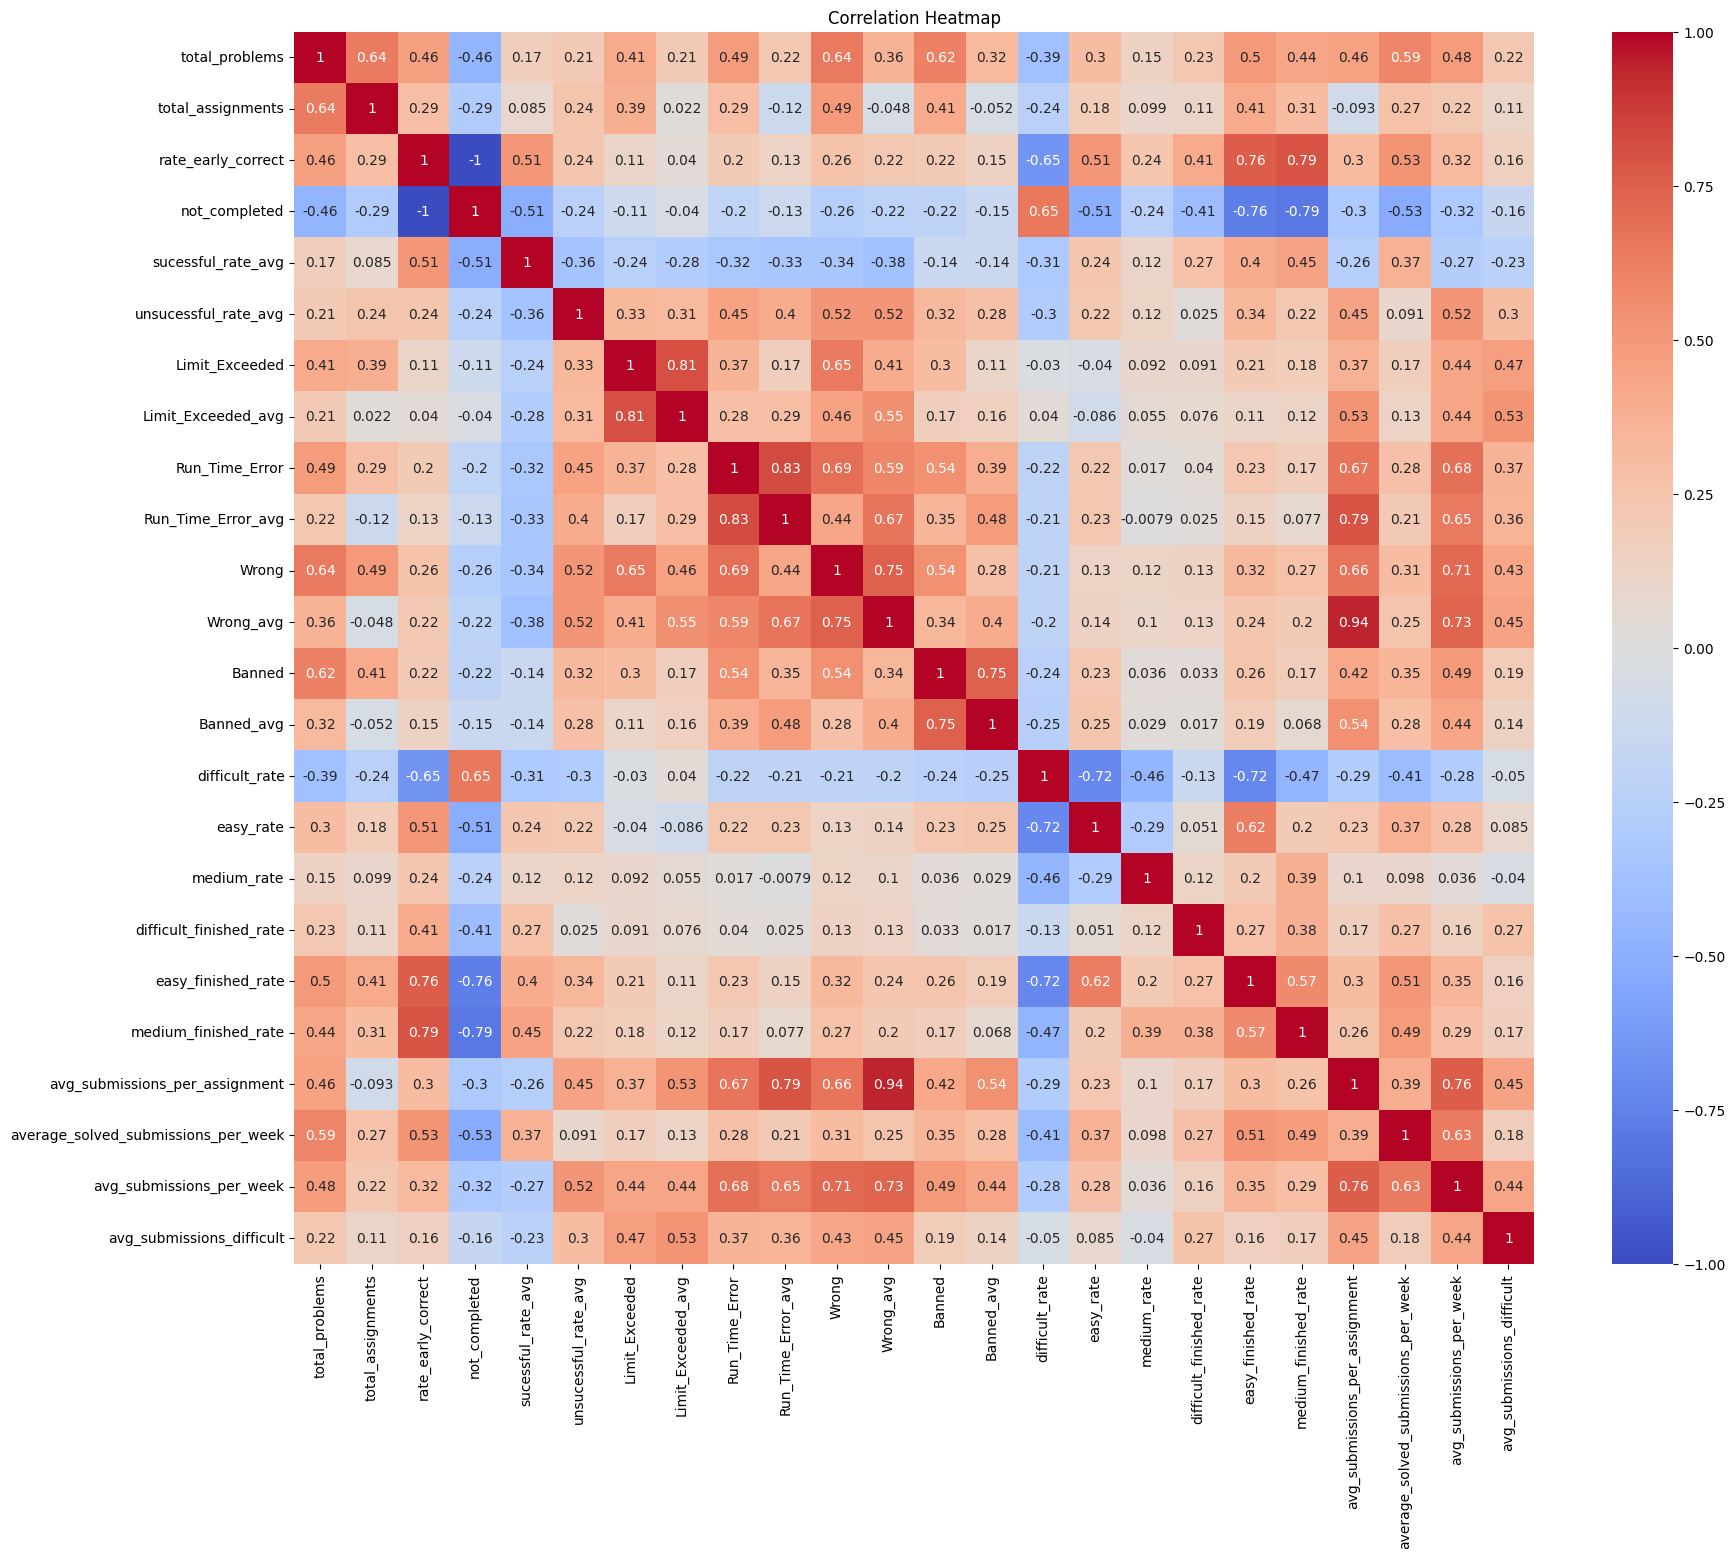

In [20]:
# Vẽ biểu đồ heatmap tương quan
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_qt, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [21]:
# Hợp nhất full_df_temp với df_qt dựa trên 'username' và 'hash'
full_df_temp_qt_merged = pd.merge(full_df_temp_qt, df_qt, left_on='username', right_on='hash', how='left')

In [22]:
# Lọc các dòng có 'username' có mặt trong df_qt['hash']
full_df_temp_qt_merged = full_df_temp_qt_merged[full_df_temp_qt_merged['username'].isin(df_qt['hash'])]

In [23]:
# Loại bỏ cột 'hash' từ full_df_temp_qt
full_df_temp_qt_merged.drop(columns=['hash'], inplace = True)

In [24]:
# Chuyển đổi cột 'diemqt' sang kiểu số
full_df_temp_qt_merged['diemqt'] = pd.to_numeric(full_df_temp_qt_merged['diemqt'], errors='coerce')

# Loại bỏ các dòng có giá trị 'diemqt' không phải số
full_df_temp_qt_merged = full_df_temp_qt_merged[pd.to_numeric(full_df_temp_qt_merged['diemqt'], errors='coerce').notnull()]

# Điền giá trị NaN bằng 0
full_df_temp_qt_merged.fillna(0, inplace=True)

# Loại bỏ các dòng có điểm 'diemqt' nhỏ hơn hoặc bằng 5
full_df_temp_qt_merged = full_df_temp_qt_merged[full_df_temp_qt_merged['diemqt'] >= 5.5]

#### Các biểu đồ thể hiện xu hướng của data với mỗi đặc trưng

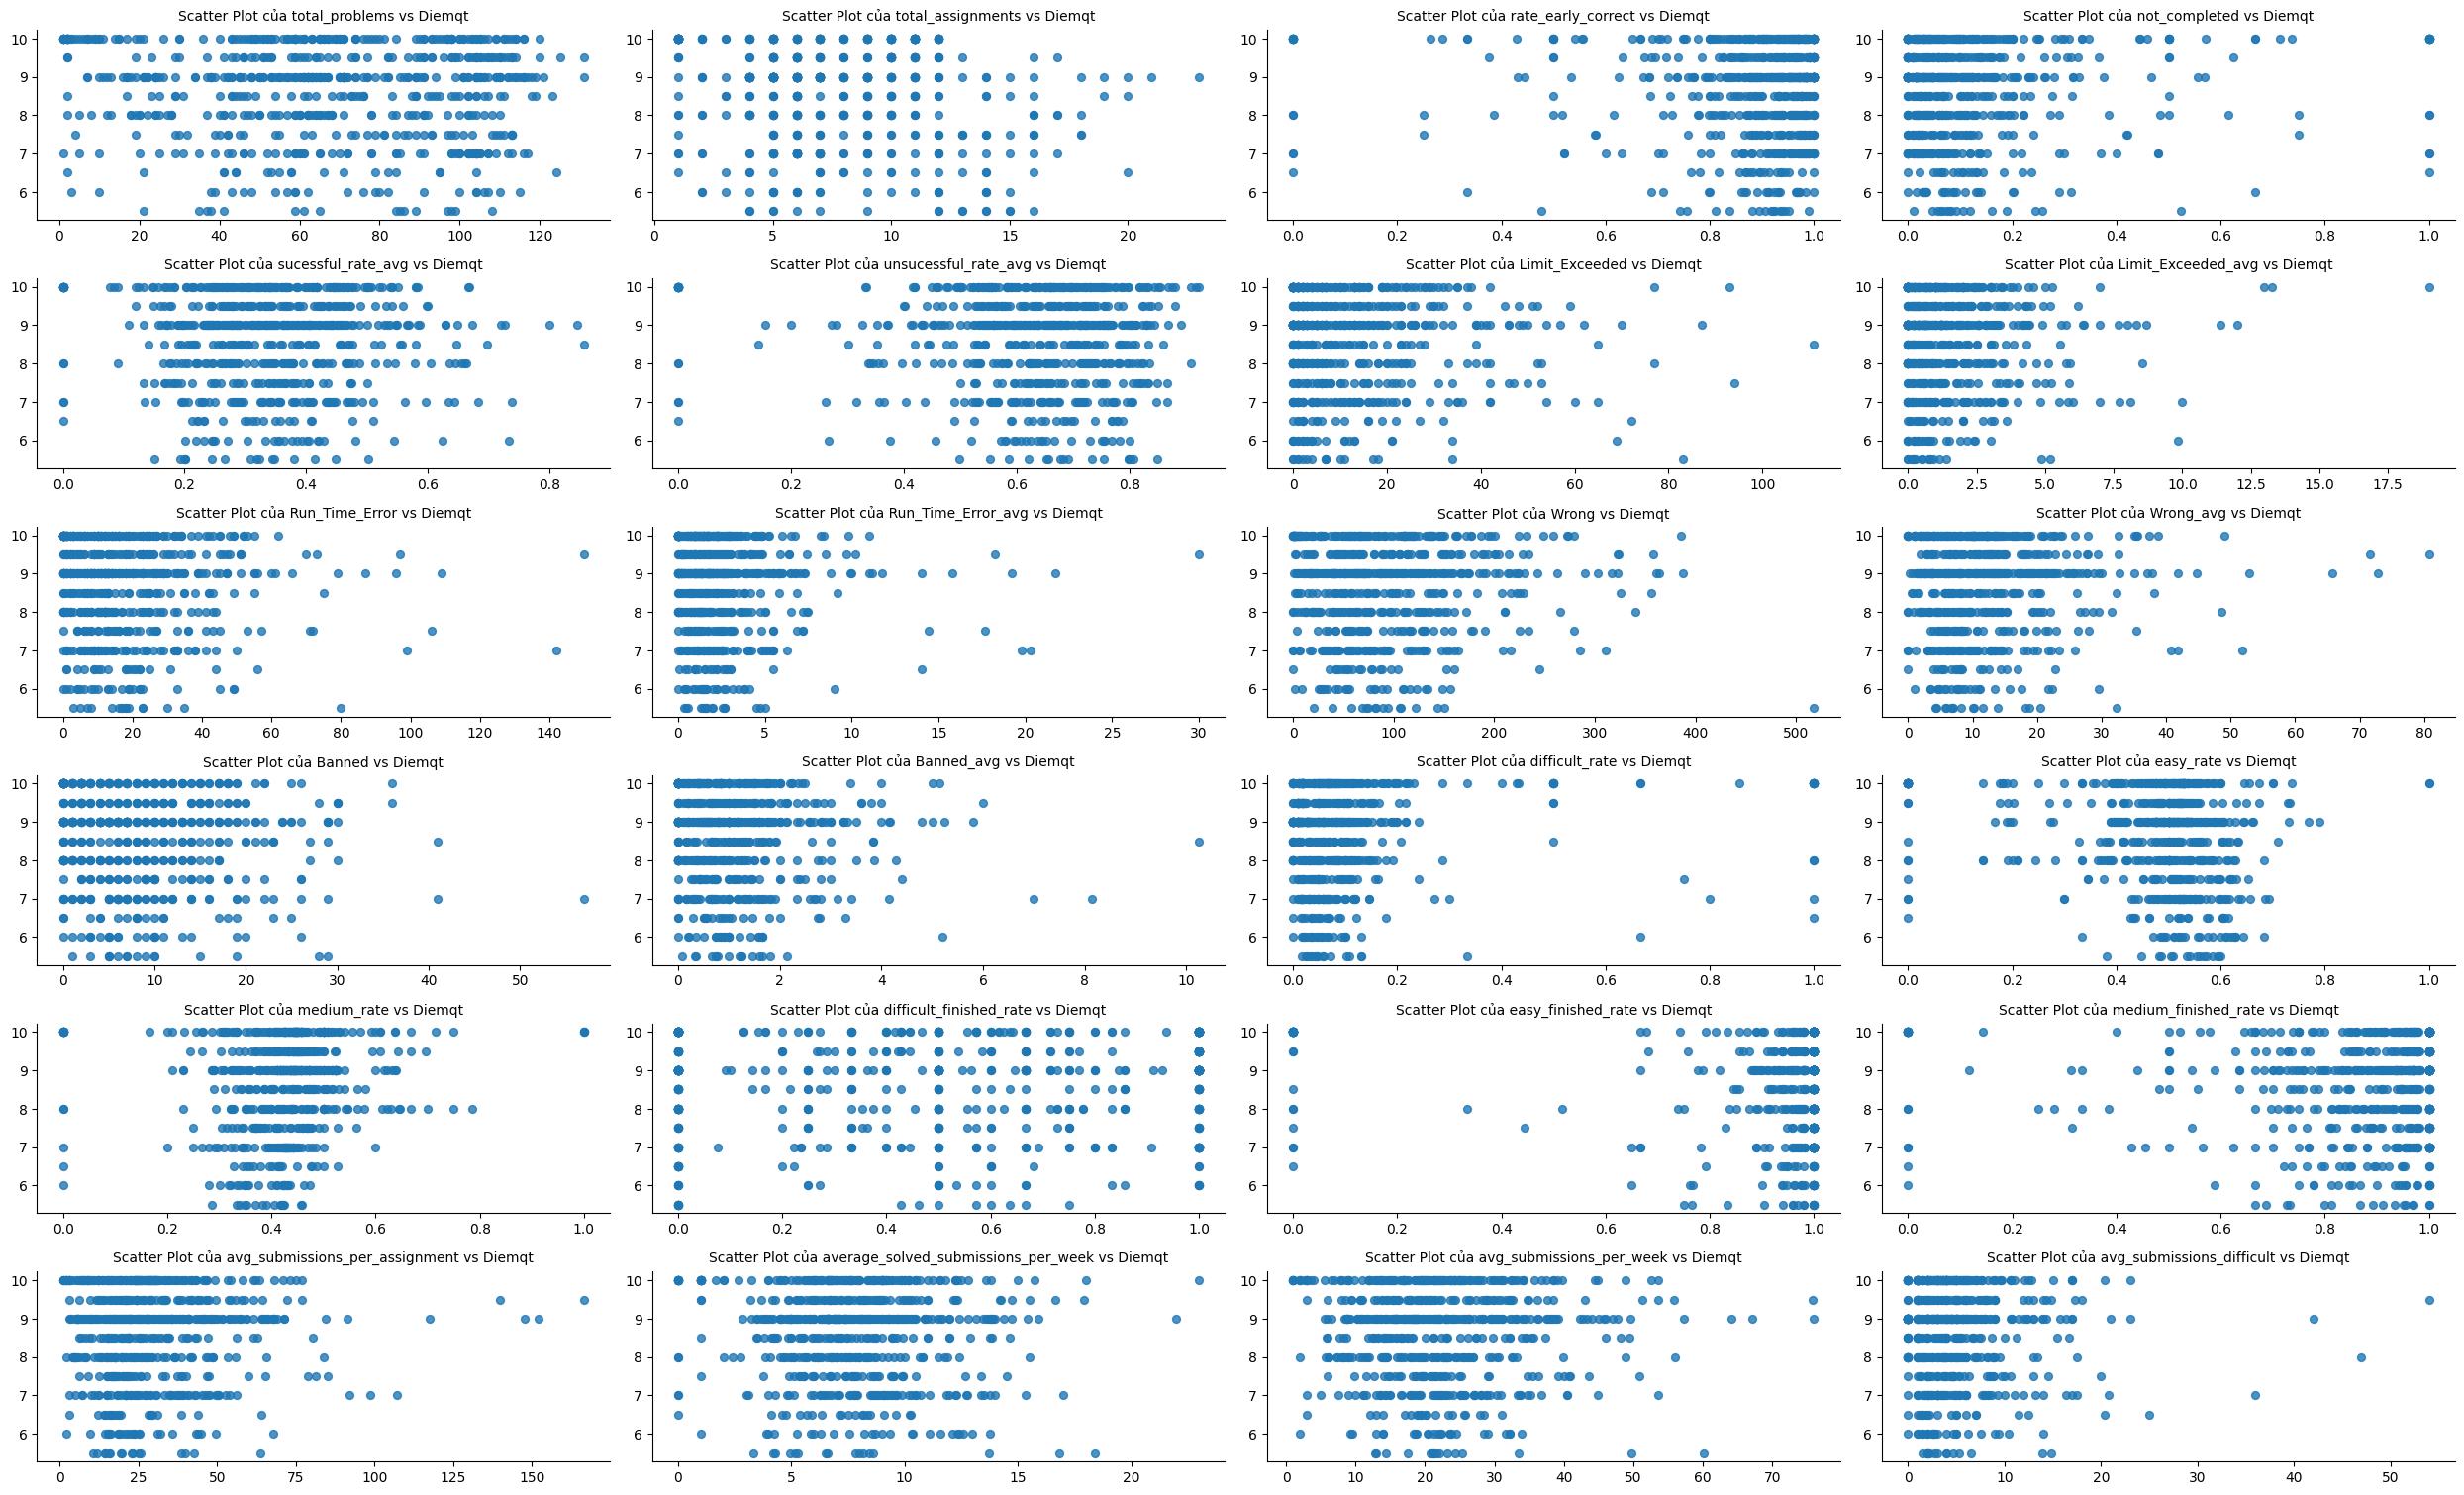

In [25]:
# Plot các scatter plot của các cột số học đối với 'diemqt'
fig, axs = plt.subplots(10, 4, figsize=(25, 25))  # 10 hàng, 4 cột

# Giải phóng mảng axs để dễ dàng lặp
axs = axs.flatten()

# Lặp qua các cột và tạo scatter plot
for i, column in enumerate(full_df_temp_qt_merged.columns[1:-1]):  # Lặp qua các cột ngoại trừ cột đầu tiên và cột cuối cùng
    axs[i].scatter(full_df_temp_qt_merged[column], full_df_temp_qt_merged['diemqt'], s=32, alpha=0.8)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(f'Scatter Plot của {column} vs Diemqt', size=10)

# Xóa các subplot trống
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [26]:
full_df_temp_qt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   username                             1489 non-null   object 
 1   total_problems                       1489 non-null   int64  
 2   total_assignments                    1489 non-null   int64  
 3   rate_early_correct                   1489 non-null   float64
 4   not_completed                        1489 non-null   float64
 5   sucessful_rate_avg                   1489 non-null   float64
 6   unsucessful_rate_avg                 1489 non-null   float64
 7   Limit_Exceeded                       1489 non-null   int64  
 8   Limit_Exceeded_avg                   1489 non-null   float64
 9   Run_Time_Error                       1489 non-null   int64  
 10  Run_Time_Error_avg                   1489 non-null   float64
 11  Wrong                         

In [27]:
full_df_temp_qt

username  total_problems  \
0     00b6dd4fc7eb817e03708c532016ef30ce564a61              46   
1     00bef8afee8f3c595d535c9c03c490cac1a4f021              78   
2     01122b3ef7e59b84189e65985305f575d6bdf83c              66   
3     0134f9f410c65ad0e8c2254a7e9288670e02a183              47   
4     013de369c439ab0ead8aa7da64423aa395a8be39              52   
...                                        ...             ...   
1484  feb8a2859a011c59efd22ed419cb69288fe03627              34   
1485  fef4a3263ed9a8ab14d457694bb8fd86ccd98312              77   
1486  ff12d6e2ab80696ed8e22fbe5497e96c68d29076             100   
1487  ff3fa2ec64294f37ae968159f810ebeda7966c51              34   
1488  ffe872165621d735a48bb5db0c71dd5195cba359              96   

      total_assignments  rate_early_correct  not_completed  \
0                     7            1.000000       0.000000   
1                     9            0.923077       0.076923   
2                     7            0.878788       0.121212   
3                     4            1.000000       0.000000   
4                     8            0.846154       0.153846   
...                 ...                 ...            ...   
1484                  9            1.000000       0.000000   
1485                  6            0.961039       0.038961   
1486                  6            0.990000       0.010000   
1487                  7            0.882353       0.117647   
1488                 10            1.000000       0.000000   

      sucessful_rate_avg  unsucessful_rate_avg  Limit_Exceeded  \
0               0.367347              0.632653               6   
1               0.328185              0.671815               5   
2               0.302564              0.697436              18   
3               0.520000              0.480000               1   
4               0.551402              0.448598               6   
...                  ...                   ...             ...   
1484            0.540541              0.459459               0   
1485            0.307692              0.692308               1   
1486            0.240275              0.759725              22   
1487            0.319149              0.680851               7   
1488            0.345865              0.654135              26   

      Limit_Exceeded_avg  Run_Time_Error  ...  difficult_rate  easy_rate  \
0               0.857143              16  ...        0.108696   0.413043   
1               0.555556              23  ...        0.064103   0.500000   
2               2.571429              12  ...        0.151515   0.409091   
3               0.250000              14  ...        0.021277   0.680851   
4               0.750000               9  ...        0.153846   0.519231   
...                  ...             ...  ...             ...        ...   
1484            0.000000               3  ...        0.058824   0.588235   
1485            0.166667              14  ...        0.025974   0.506494   
1486            3.666667              18  ...        0.030000   0.540000   
1487            1.000000               9  ...        0.088235   0.470588   
1488            2.600000              15  ...        0.010417   0.541667   

      medium_rate  difficult_finished_rate  easy_finished_rate  \
0        0.478261                 1.000000            1.000000   
1        0.435897                 0.400000            0.974359   
2        0.439394                 0.500000            1.000000   
3        0.297872                 1.000000            1.000000   
4        0.326923                 0.125000            1.000000   
...           ...                      ...                 ...   
1484     0.352941                 1.000000            1.000000   
1485     0.467532                 0.500000            1.000000   
1486     0.430000                 0.666667            1.000000   
1487     0.441176                 0.333333            1.000000   
1488     0.447917                 1.000000            1.000000   

 

## 4.2. TH

In [28]:
# Tạo bản sao của df_statistics để phân tích
full_df_temp_th = df_statistics.copy()

In [29]:
# Tính ma trận tương quan cho tất cả các cột ngoại trừ 'username'
full_df_temp_th_corr = full_df_temp_th.drop(columns=['username'])
corr_matrix_th = full_df_temp_th_corr.corr()

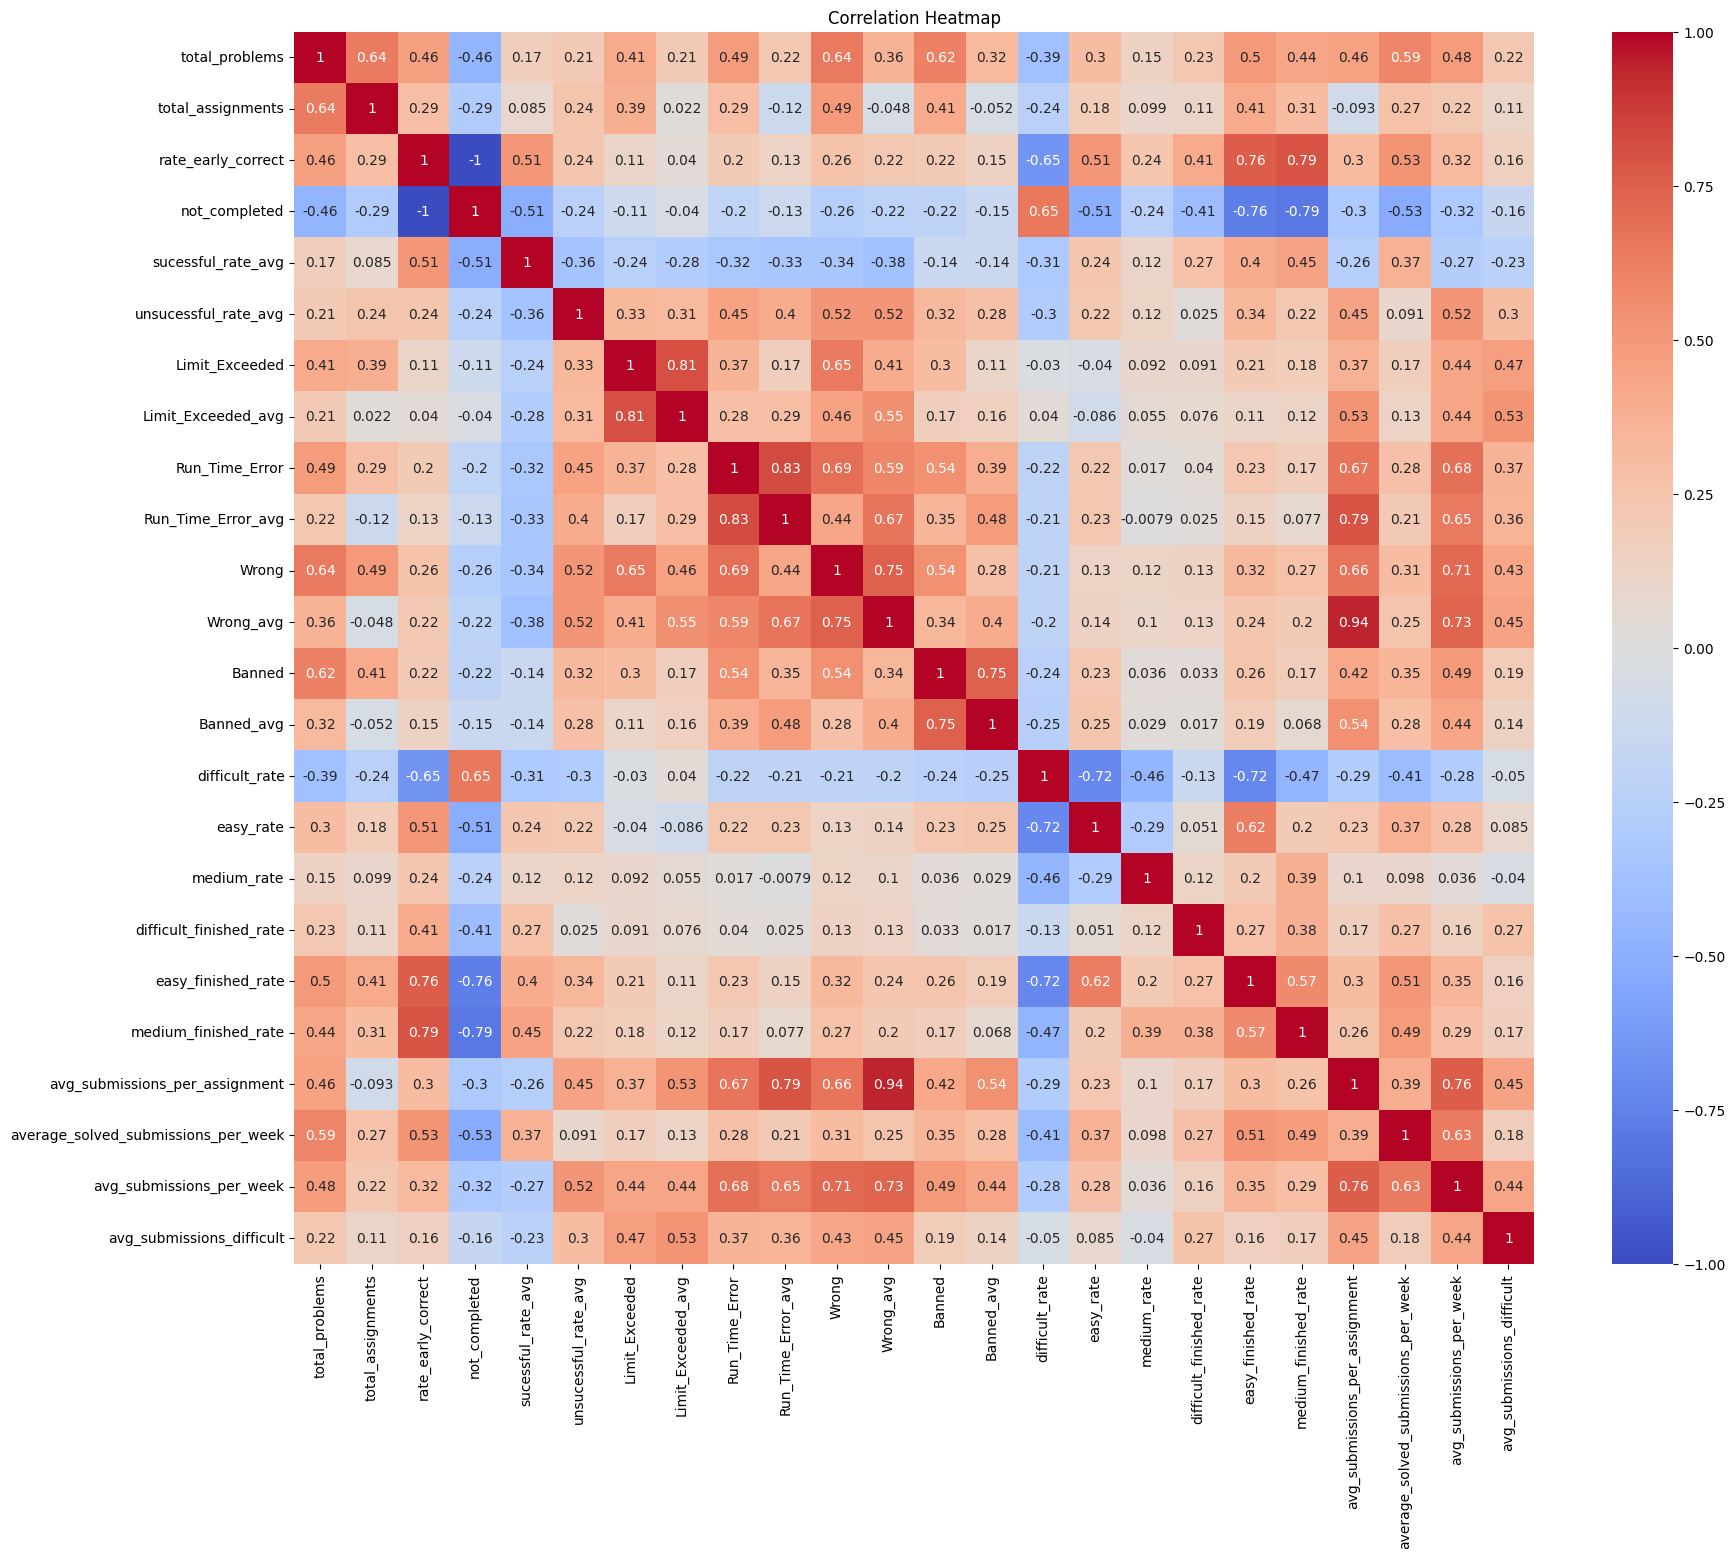

In [30]:
# Vẽ biểu đồ heatmap tương quan
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_th, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [31]:
# Hợp nhất full_df_temp với df_th dựa trên 'username' và 'hash'
full_df_temp_th_merged = pd.merge(full_df_temp_th, df_th, left_on='username', right_on='hash', how='left')

In [32]:
# Lọc các dòng có 'username' có mặt trong df_th['hash']
full_df_temp_th_merged = full_df_temp_th_merged[full_df_temp_th_merged['username'].isin(df_th['hash'])]

In [33]:
# Loại bỏ cột 'hash' từ full_df_temp_th
full_df_temp_th_merged.drop(columns=['hash'], inplace = True)

In [34]:
# Chuyển đổi cột 'TH' sang kiểu số
full_df_temp_th_merged['TH'] = pd.to_numeric(full_df_temp_th_merged['TH'], errors='coerce')

# Loại bỏ các dòng có giá trị 'TH' không phải số
full_df_temp_th_merged = full_df_temp_th_merged[pd.to_numeric(full_df_temp_th_merged['TH'], errors='coerce').notnull()]

#### Các biểu đồ thể hiện xu hướng của data với mỗi đặc trưng

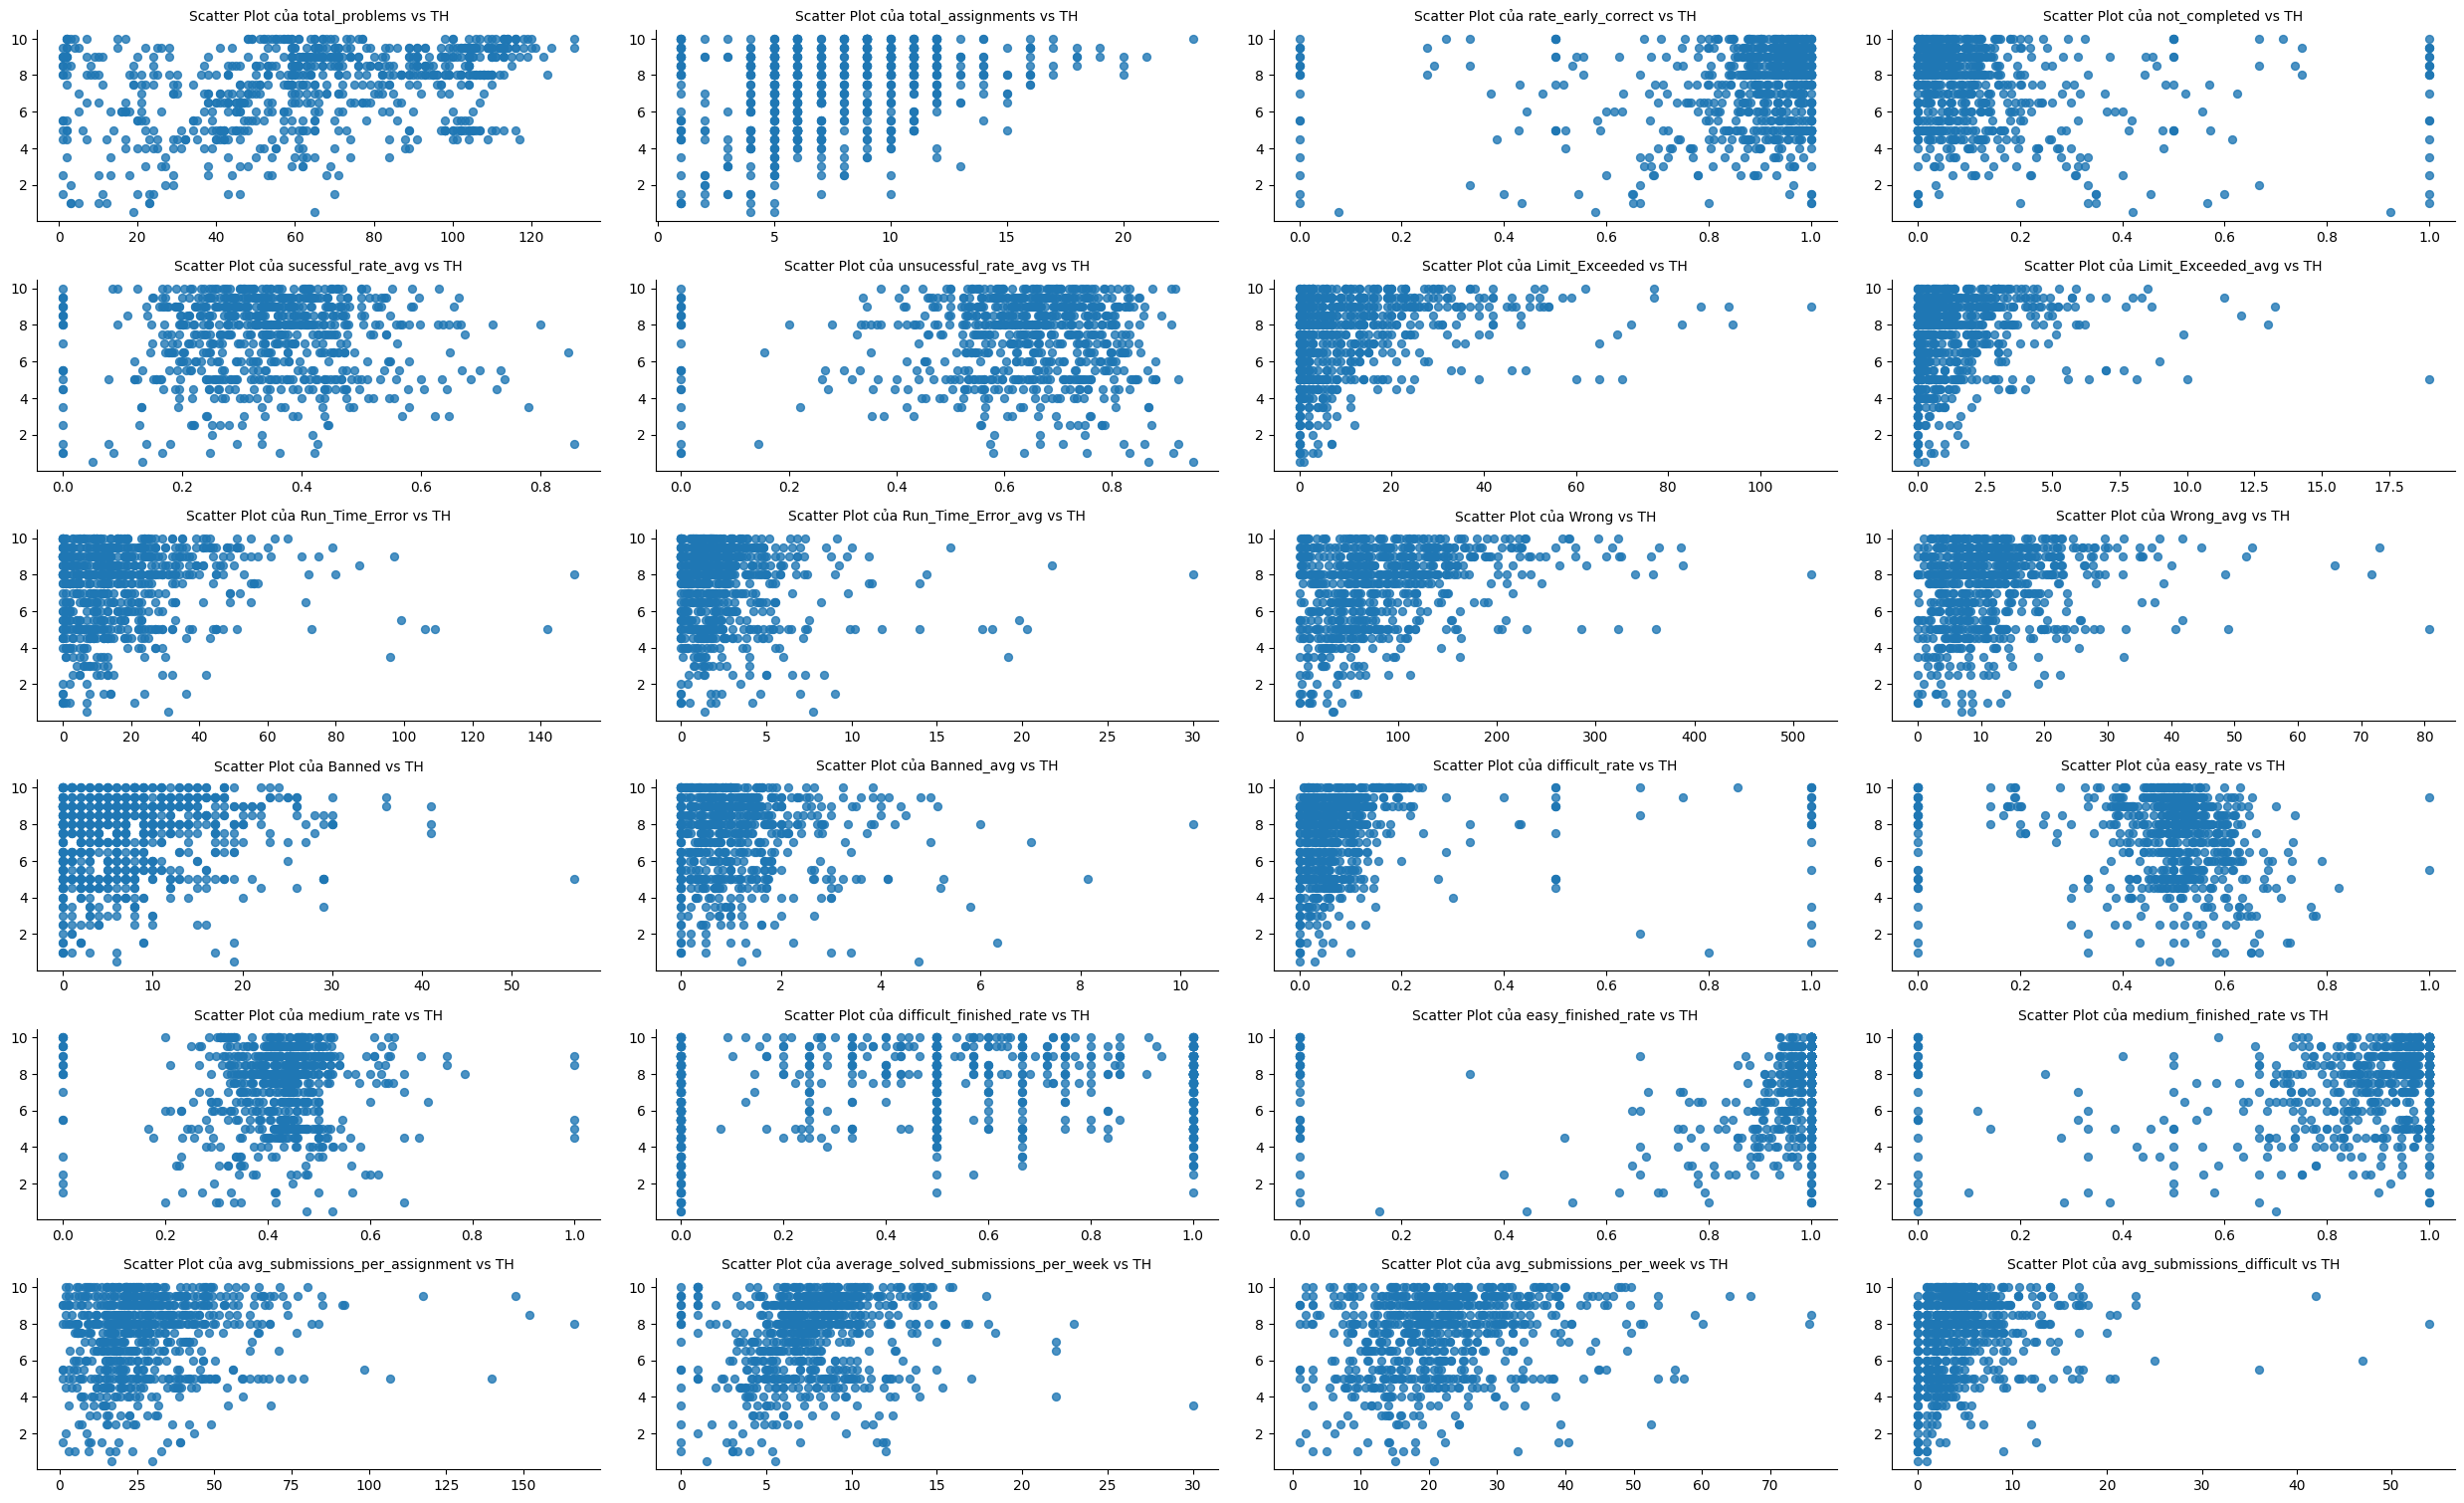

In [35]:
# Plot các scatter plot của các cột số học đối với 'TH'
fig, axs = plt.subplots(10, 4, figsize=(25, 25))  # 10 hàng, 4 cột

# Giải phóng mảng axs để dễ dàng lặp
axs = axs.flatten()

# Lặp qua các cột và tạo scatter plot
for i, column in enumerate(full_df_temp_th_merged.columns[1:-1]):  # Lặp qua các cột ngoại trừ cột đầu tiên và cột cuối cùng
    axs[i].scatter(full_df_temp_th_merged[column], full_df_temp_th_merged['TH'], s=32, alpha=0.8)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(f'Scatter Plot của {column} vs TH', size=10)

# Xóa các subplot trống
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [36]:
full_df_temp_th

username  total_problems  \
0     00b6dd4fc7eb817e03708c532016ef30ce564a61              46   
1     00bef8afee8f3c595d535c9c03c490cac1a4f021              78   
2     01122b3ef7e59b84189e65985305f575d6bdf83c              66   
3     0134f9f410c65ad0e8c2254a7e9288670e02a183              47   
4     013de369c439ab0ead8aa7da64423aa395a8be39              52   
...                                        ...             ...   
1484  feb8a2859a011c59efd22ed419cb69288fe03627              34   
1485  fef4a3263ed9a8ab14d457694bb8fd86ccd98312              77   
1486  ff12d6e2ab80696ed8e22fbe5497e96c68d29076             100   
1487  ff3fa2ec64294f37ae968159f810ebeda7966c51              34   
1488  ffe872165621d735a48bb5db0c71dd5195cba359              96   

      total_assignments  rate_early_correct  not_completed  \
0                     7            1.000000       0.000000   
1                     9            0.923077       0.076923   
2                     7            0.878788       0.121212   
3                     4            1.000000       0.000000   
4                     8            0.846154       0.153846   
...                 ...                 ...            ...   
1484                  9            1.000000       0.000000   
1485                  6            0.961039       0.038961   
1486                  6            0.990000       0.010000   
1487                  7            0.882353       0.117647   
1488                 10            1.000000       0.000000   

      sucessful_rate_avg  unsucessful_rate_avg  Limit_Exceeded  \
0               0.367347              0.632653               6   
1               0.328185              0.671815               5   
2               0.302564              0.697436              18   
3               0.520000              0.480000               1   
4               0.551402              0.448598               6   
...                  ...                   ...             ...   
1484            0.540541              0.459459               0   
1485            0.307692              0.692308               1   
1486            0.240275              0.759725              22   
1487            0.319149              0.680851               7   
1488            0.345865              0.654135              26   

      Limit_Exceeded_avg  Run_Time_Error  ...  difficult_rate  easy_rate  \
0               0.857143              16  ...        0.108696   0.413043   
1               0.555556              23  ...        0.064103   0.500000   
2               2.571429              12  ...        0.151515   0.409091   
3               0.250000              14  ...        0.021277   0.680851   
4               0.750000               9  ...        0.153846   0.519231   
...                  ...             ...  ...             ...        ...   
1484            0.000000               3  ...        0.058824   0.588235   
1485            0.166667              14  ...        0.025974   0.506494   
1486            3.666667              18  ...        0.030000   0.540000   
1487            1.000000               9  ...        0.088235   0.470588   
1488            2.600000              15  ...        0.010417   0.541667   

      medium_rate  difficult_finished_rate  easy_finished_rate  \
0        0.478261                 1.000000            1.000000   
1        0.435897                 0.400000            0.974359   
2        0.439394                 0.500000            1.000000   
3        0.297872                 1.000000            1.000000   
4        0.326923                 0.125000            1.000000   
...           ...                      ...                 ...   
1484     0.352941                 1.000000            1.000000   
1485     0.467532                 0.500000            1.000000   
1486     0.430000                 0.666667            1.000000   
1487     0.441176                 0.333333            1.000000   
1488     0.447917                 1.000000            1.000000   

 

## 4.3. TBTL

In [37]:
# Tạo bản sao của df_statistics để phân tích
full_df_temp_tbtl = df_statistics.copy()

In [38]:
# Tính ma trận tương quan cho tất cả các cột ngoại trừ 'username'
full_df_temp_tbtl_corr = full_df_temp_tbtl.drop(columns=['username'])
corr_matrix_tbtl = full_df_temp_tbtl_corr.corr()

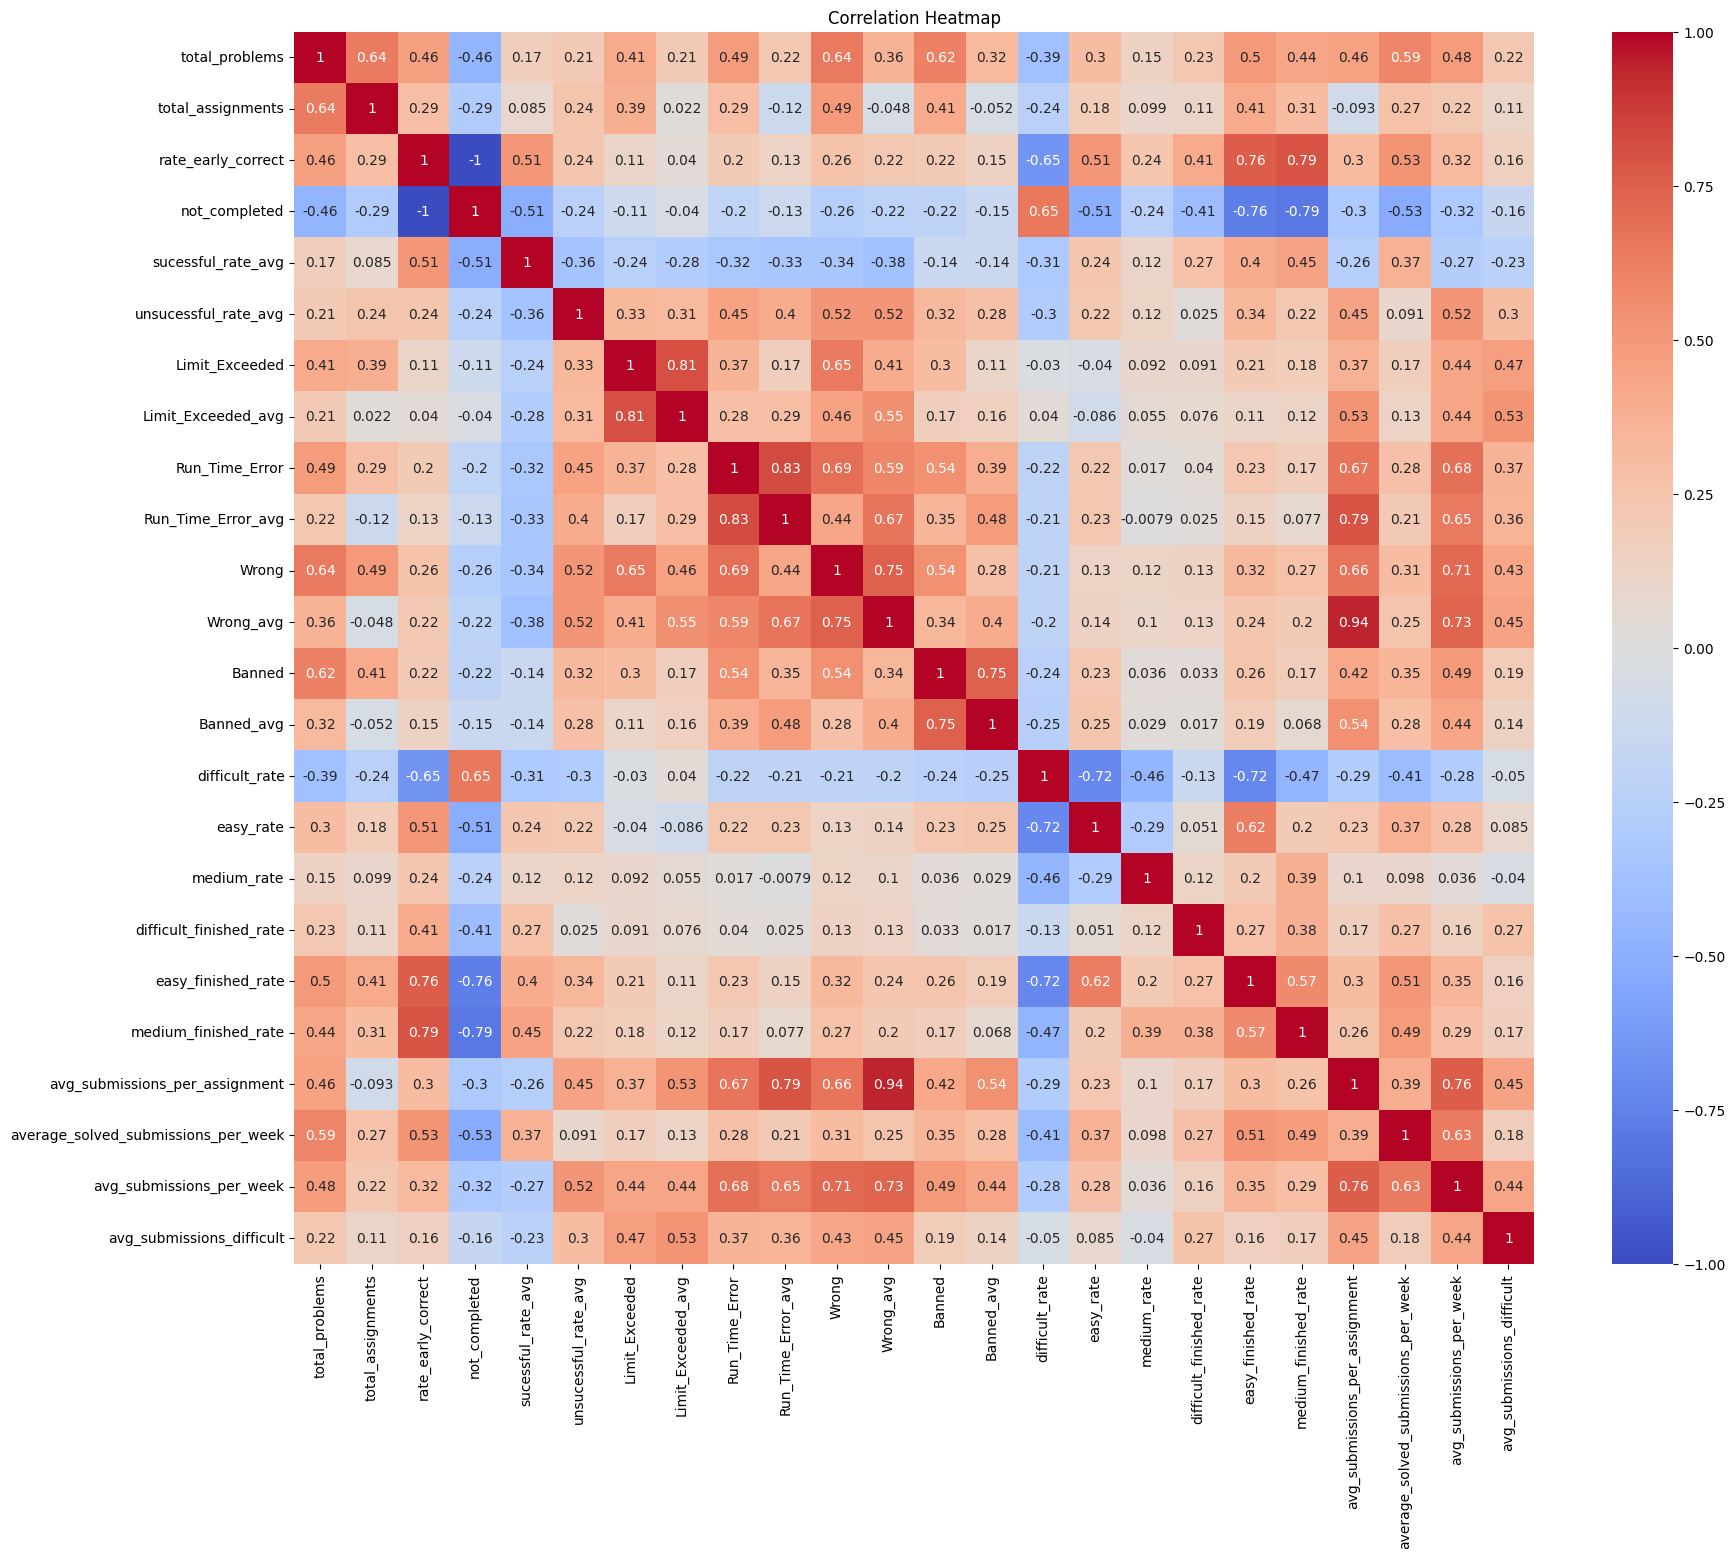

In [39]:
# Vẽ biểu đồ heatmap tương quan
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_tbtl, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [40]:
# Hợp nhất full_df_temp với df_tbtl dựa trên 'username' và 'hash'
full_df_temp_tbtl_merged = pd.merge(full_df_temp_tbtl, df_tbtl, on='username', how='left')

In [41]:
# Lọc các dòng có 'username' có mặt trong df_tbtl['hash']
full_df_temp_tbtl_merged = full_df_temp_tbtl_merged[full_df_temp_tbtl_merged['username'].isin(df_tbtl['username'])]

In [42]:
full_df_temp_tbtl_merged = full_df_temp_tbtl_merged[full_df_temp_tbtl_merged['TBTL'] >= 5]

#### Các biểu đồ thể hiện xu hướng của data với mỗi đặc trưng

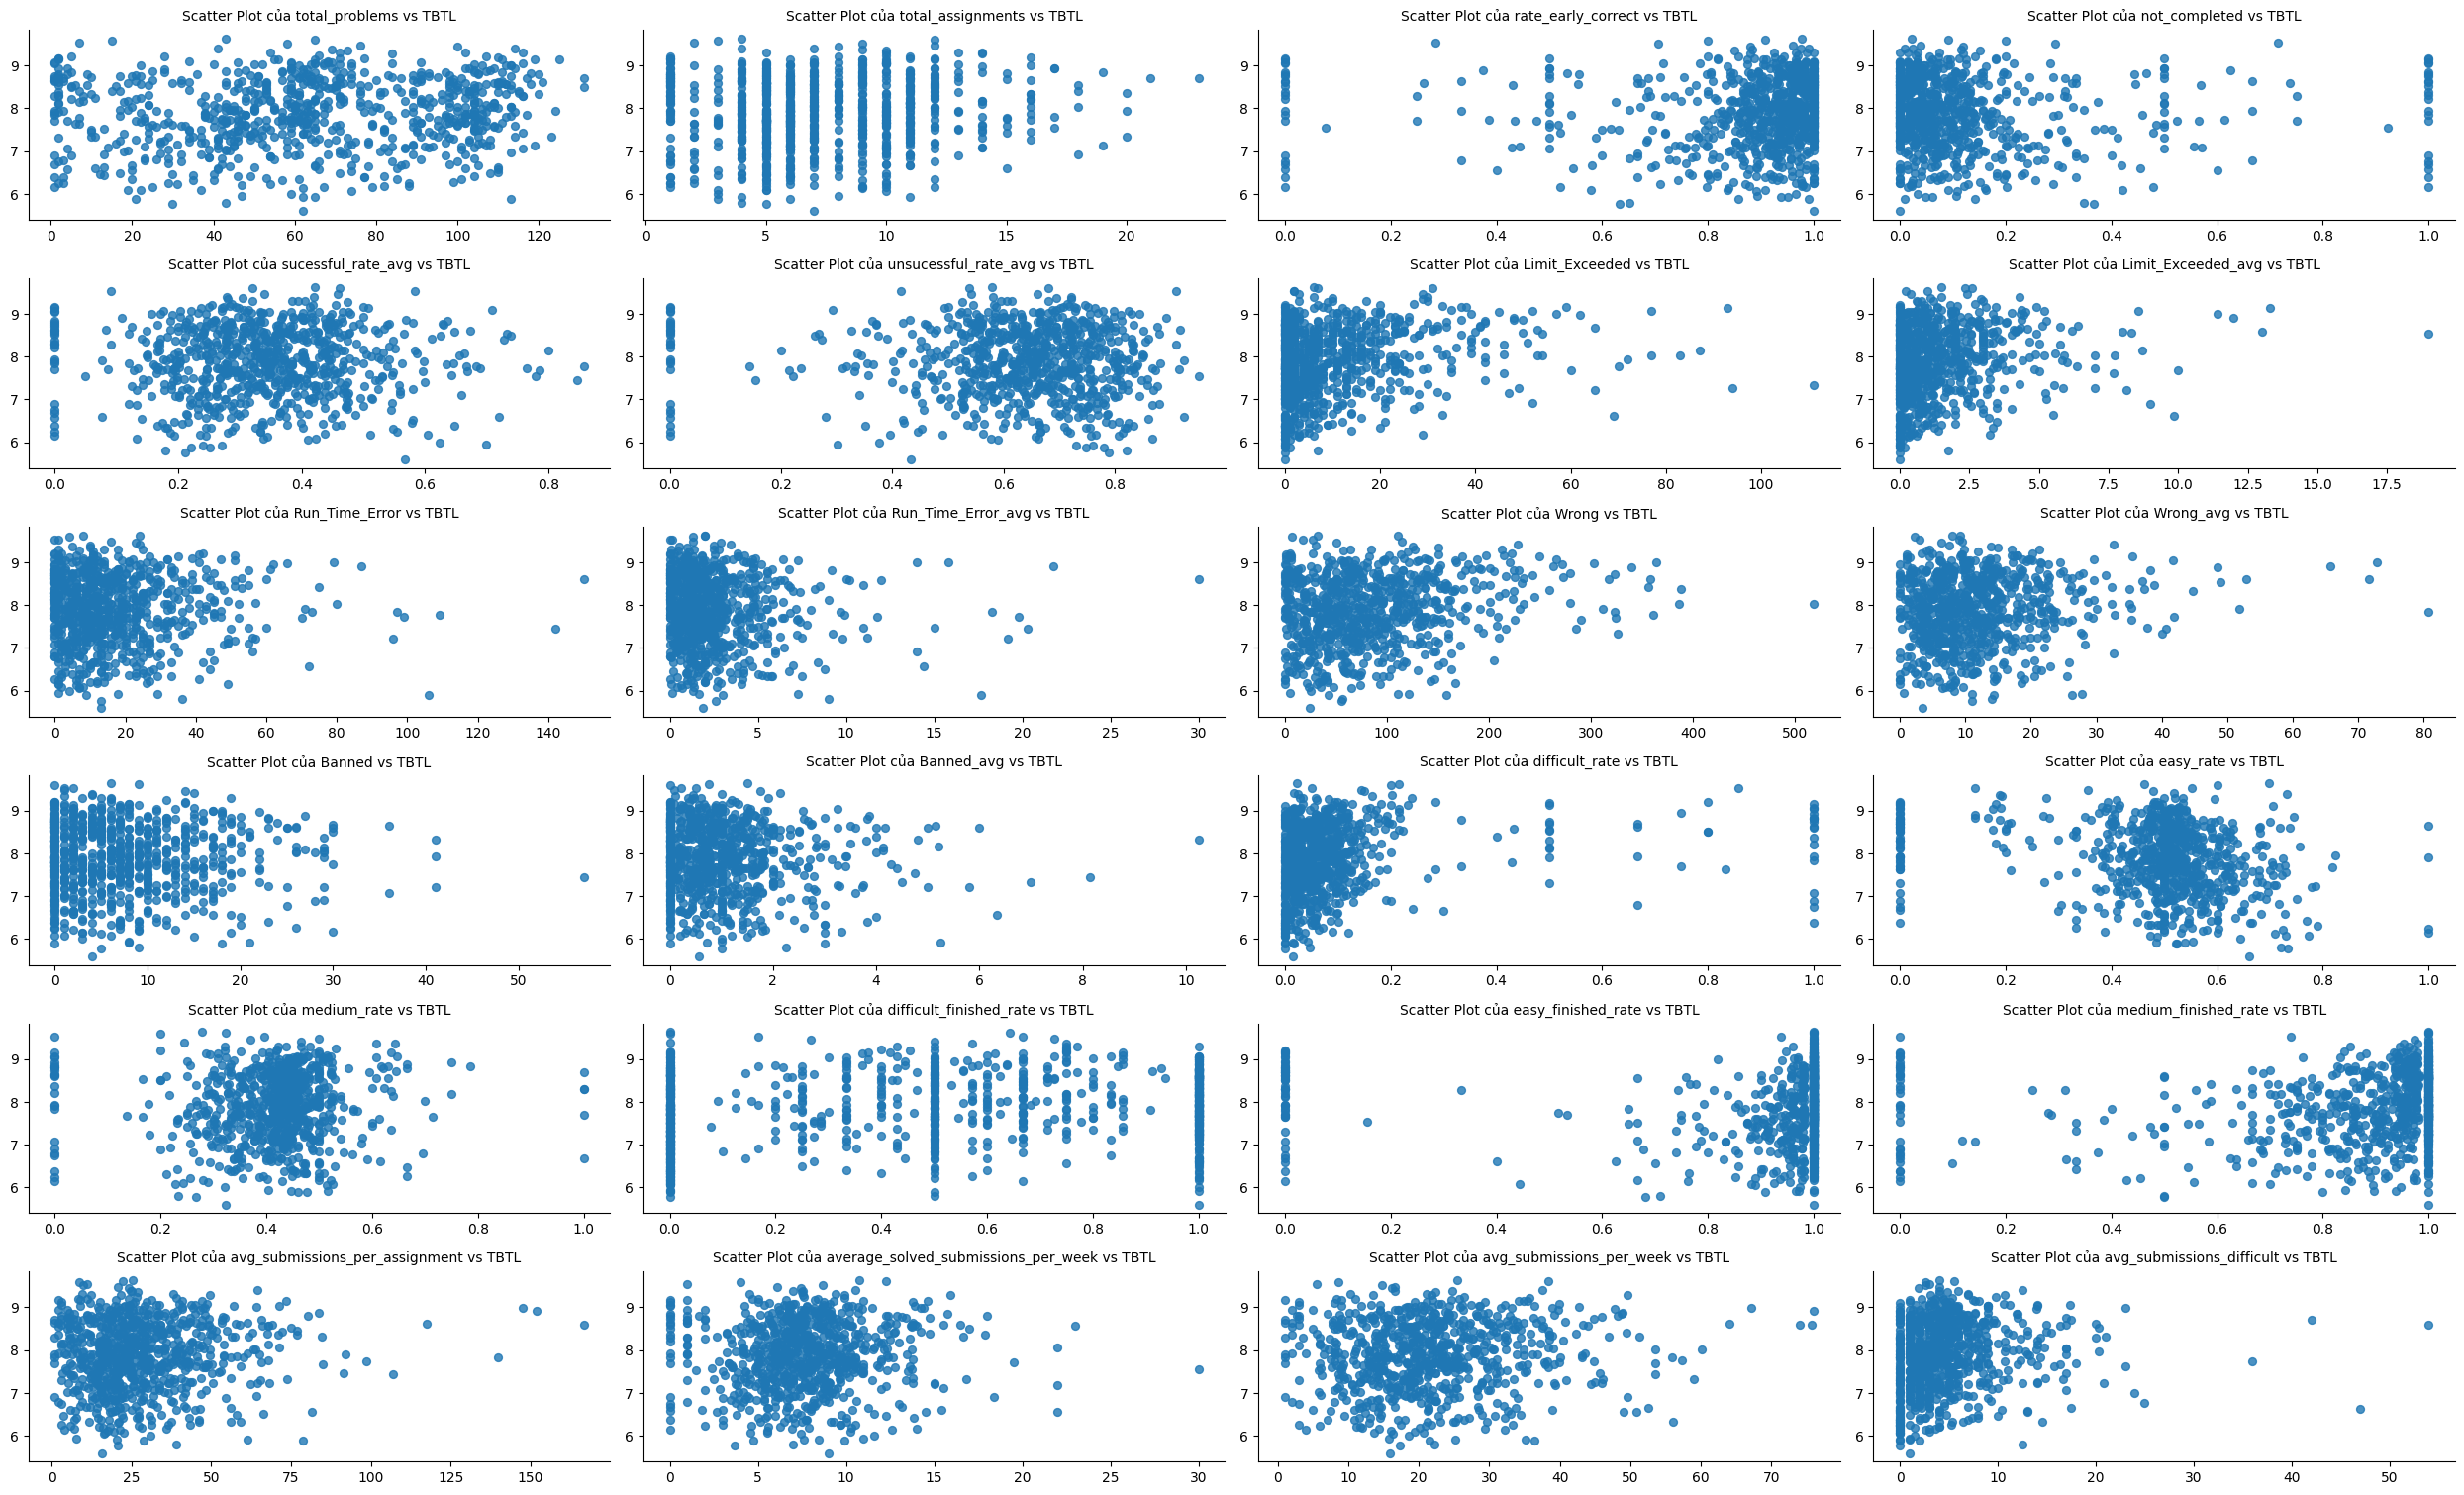

In [43]:
# Plot các scatter plot của các cột số học đối với 'TBTL'
fig, axs = plt.subplots(10, 4, figsize=(25, 25))  # 10 hàng, 4 cột

# Giải phóng mảng axs để dễ dàng lặp
axs = axs.flatten()

# Lặp qua các cột và tạo scatter plot
for i, column in enumerate(full_df_temp_tbtl_merged.columns[1:-1]):  # Lặp qua các cột ngoại trừ cột đầu tiên và cột cuối cùng
    axs[i].scatter(full_df_temp_tbtl_merged[column], full_df_temp_tbtl_merged['TBTL'], s=32, alpha=0.8)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(f'Scatter Plot của {column} vs TBTL', size=10)

# Xóa các subplot trống
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

#### Các biểu đồ thể hiện xu hướng của data với mỗi đặc trưng (sau khi lọc thêm điều kiện)

In [44]:
full_df_temp_tbtl

username  total_problems  \
0     00b6dd4fc7eb817e03708c532016ef30ce564a61              46   
1     00bef8afee8f3c595d535c9c03c490cac1a4f021              78   
2     01122b3ef7e59b84189e65985305f575d6bdf83c              66   
3     0134f9f410c65ad0e8c2254a7e9288670e02a183              47   
4     013de369c439ab0ead8aa7da64423aa395a8be39              52   
...                                        ...             ...   
1484  feb8a2859a011c59efd22ed419cb69288fe03627              34   
1485  fef4a3263ed9a8ab14d457694bb8fd86ccd98312              77   
1486  ff12d6e2ab80696ed8e22fbe5497e96c68d29076             100   
1487  ff3fa2ec64294f37ae968159f810ebeda7966c51              34   
1488  ffe872165621d735a48bb5db0c71dd5195cba359              96   

      total_assignments  rate_early_correct  not_completed  \
0                     7            1.000000       0.000000   
1                     9            0.923077       0.076923   
2                     7            0.878788       0.121212   
3                     4            1.000000       0.000000   
4                     8            0.846154       0.153846   
...                 ...                 ...            ...   
1484                  9            1.000000       0.000000   
1485                  6            0.961039       0.038961   
1486                  6            0.990000       0.010000   
1487                  7            0.882353       0.117647   
1488                 10            1.000000       0.000000   

      sucessful_rate_avg  unsucessful_rate_avg  Limit_Exceeded  \
0               0.367347              0.632653               6   
1               0.328185              0.671815               5   
2               0.302564              0.697436              18   
3               0.520000              0.480000               1   
4               0.551402              0.448598               6   
...                  ...                   ...             ...   
1484            0.540541              0.459459               0   
1485            0.307692              0.692308               1   
1486            0.240275              0.759725              22   
1487            0.319149              0.680851               7   
1488            0.345865              0.654135              26   

      Limit_Exceeded_avg  Run_Time_Error  ...  difficult_rate  easy_rate  \
0               0.857143              16  ...        0.108696   0.413043   
1               0.555556              23  ...        0.064103   0.500000   
2               2.571429              12  ...        0.151515   0.409091   
3               0.250000              14  ...        0.021277   0.680851   
4               0.750000               9  ...        0.153846   0.519231   
...                  ...             ...  ...             ...        ...   
1484            0.000000               3  ...        0.058824   0.588235   
1485            0.166667              14  ...        0.025974   0.506494   
1486            3.666667              18  ...        0.030000   0.540000   
1487            1.000000               9  ...        0.088235   0.470588   
1488            2.600000              15  ...        0.010417   0.541667   

      medium_rate  difficult_finished_rate  easy_finished_rate  \
0        0.478261                 1.000000            1.000000   
1        0.435897                 0.400000            0.974359   
2        0.439394                 0.500000            1.000000   
3        0.297872                 1.000000            1.000000   
4        0.326923                 0.125000            1.000000   
...           ...                      ...                 ...   
1484     0.352941                 1.000000            1.000000   
1485     0.467532                 0.500000            1.000000   
1486     0.430000                 0.666667            1.000000   
1487     0.441176                 0.333333            1.000000   
1488     0.447917                 1.000000            1.000000   

 

## 4.4. CK

In [45]:
# Tạo bản sao của df_statistics để phân tích
full_df_temp_ck = df_statistics.copy()

In [46]:
# Tính ma trận tương quan cho tất cả các cột ngoại trừ 'username'
full_df_temp_ck_corr = full_df_temp_ck.drop(columns=['username'])
corr_matrix_ck = full_df_temp_ck_corr.corr()

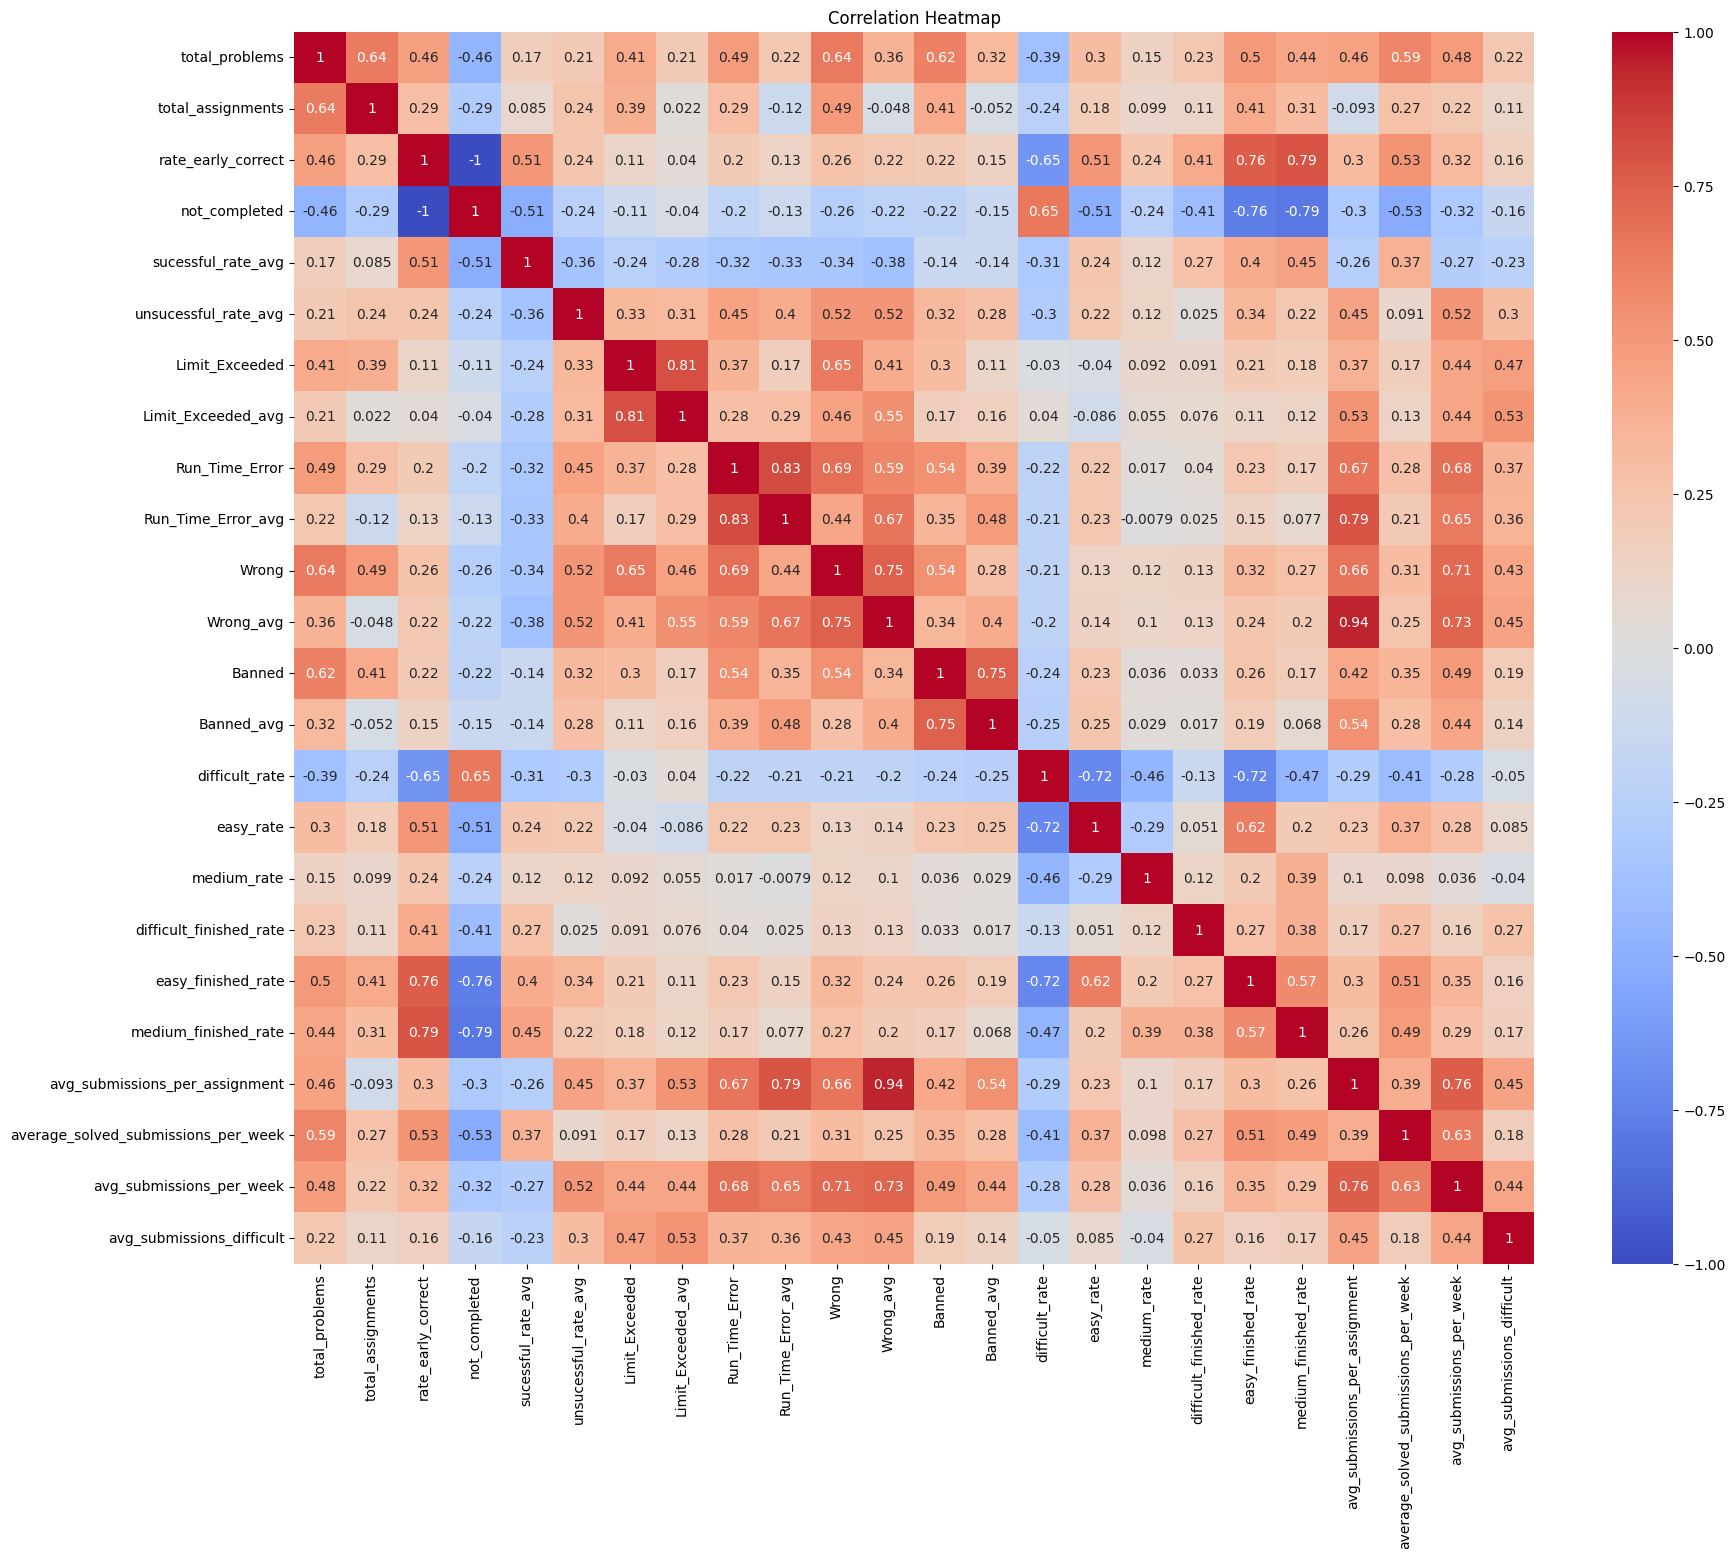

In [47]:
# Vẽ biểu đồ heatmap tương quan
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_ck, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [48]:
# Hợp nhất full_df_temp với df_ck dựa trên 'username' và 'hash'
full_df_temp_ck_merged = pd.merge(full_df_temp_ck, df_ck, left_on='username', right_on='hash', how='left')

In [49]:
# Lọc các dòng có 'username' có mặt trong df_ck['hash']
full_df_temp_ck_merged = full_df_temp_ck_merged[full_df_temp_ck_merged['username'].isin(df_ck['hash'])]

In [50]:
# Loại bỏ cột 'hash' từ full_df_temp_ck
full_df_temp_ck_merged.drop(columns=['hash'], inplace = True)

In [51]:
# Chuyển đổi cột 'CK' sang kiểu số
full_df_temp_ck_merged['CK'] = pd.to_numeric(full_df_temp_ck_merged['CK'], errors='coerce')

# Loại bỏ các dòng có giá trị 'CK' không phải số
full_df_temp_ck_merged = full_df_temp_ck_merged[pd.to_numeric(full_df_temp_ck_merged['CK'], errors='coerce').notnull()]

# # Loại bỏ các dòng có điểm 'CK' nhỏ hơn 2
full_df_temp_ck_merged = full_df_temp_ck_merged[full_df_temp_ck_merged['CK'] >= 2]

#### Các biểu đồ thể hiện xu hướng của data với mỗi đặc trưng

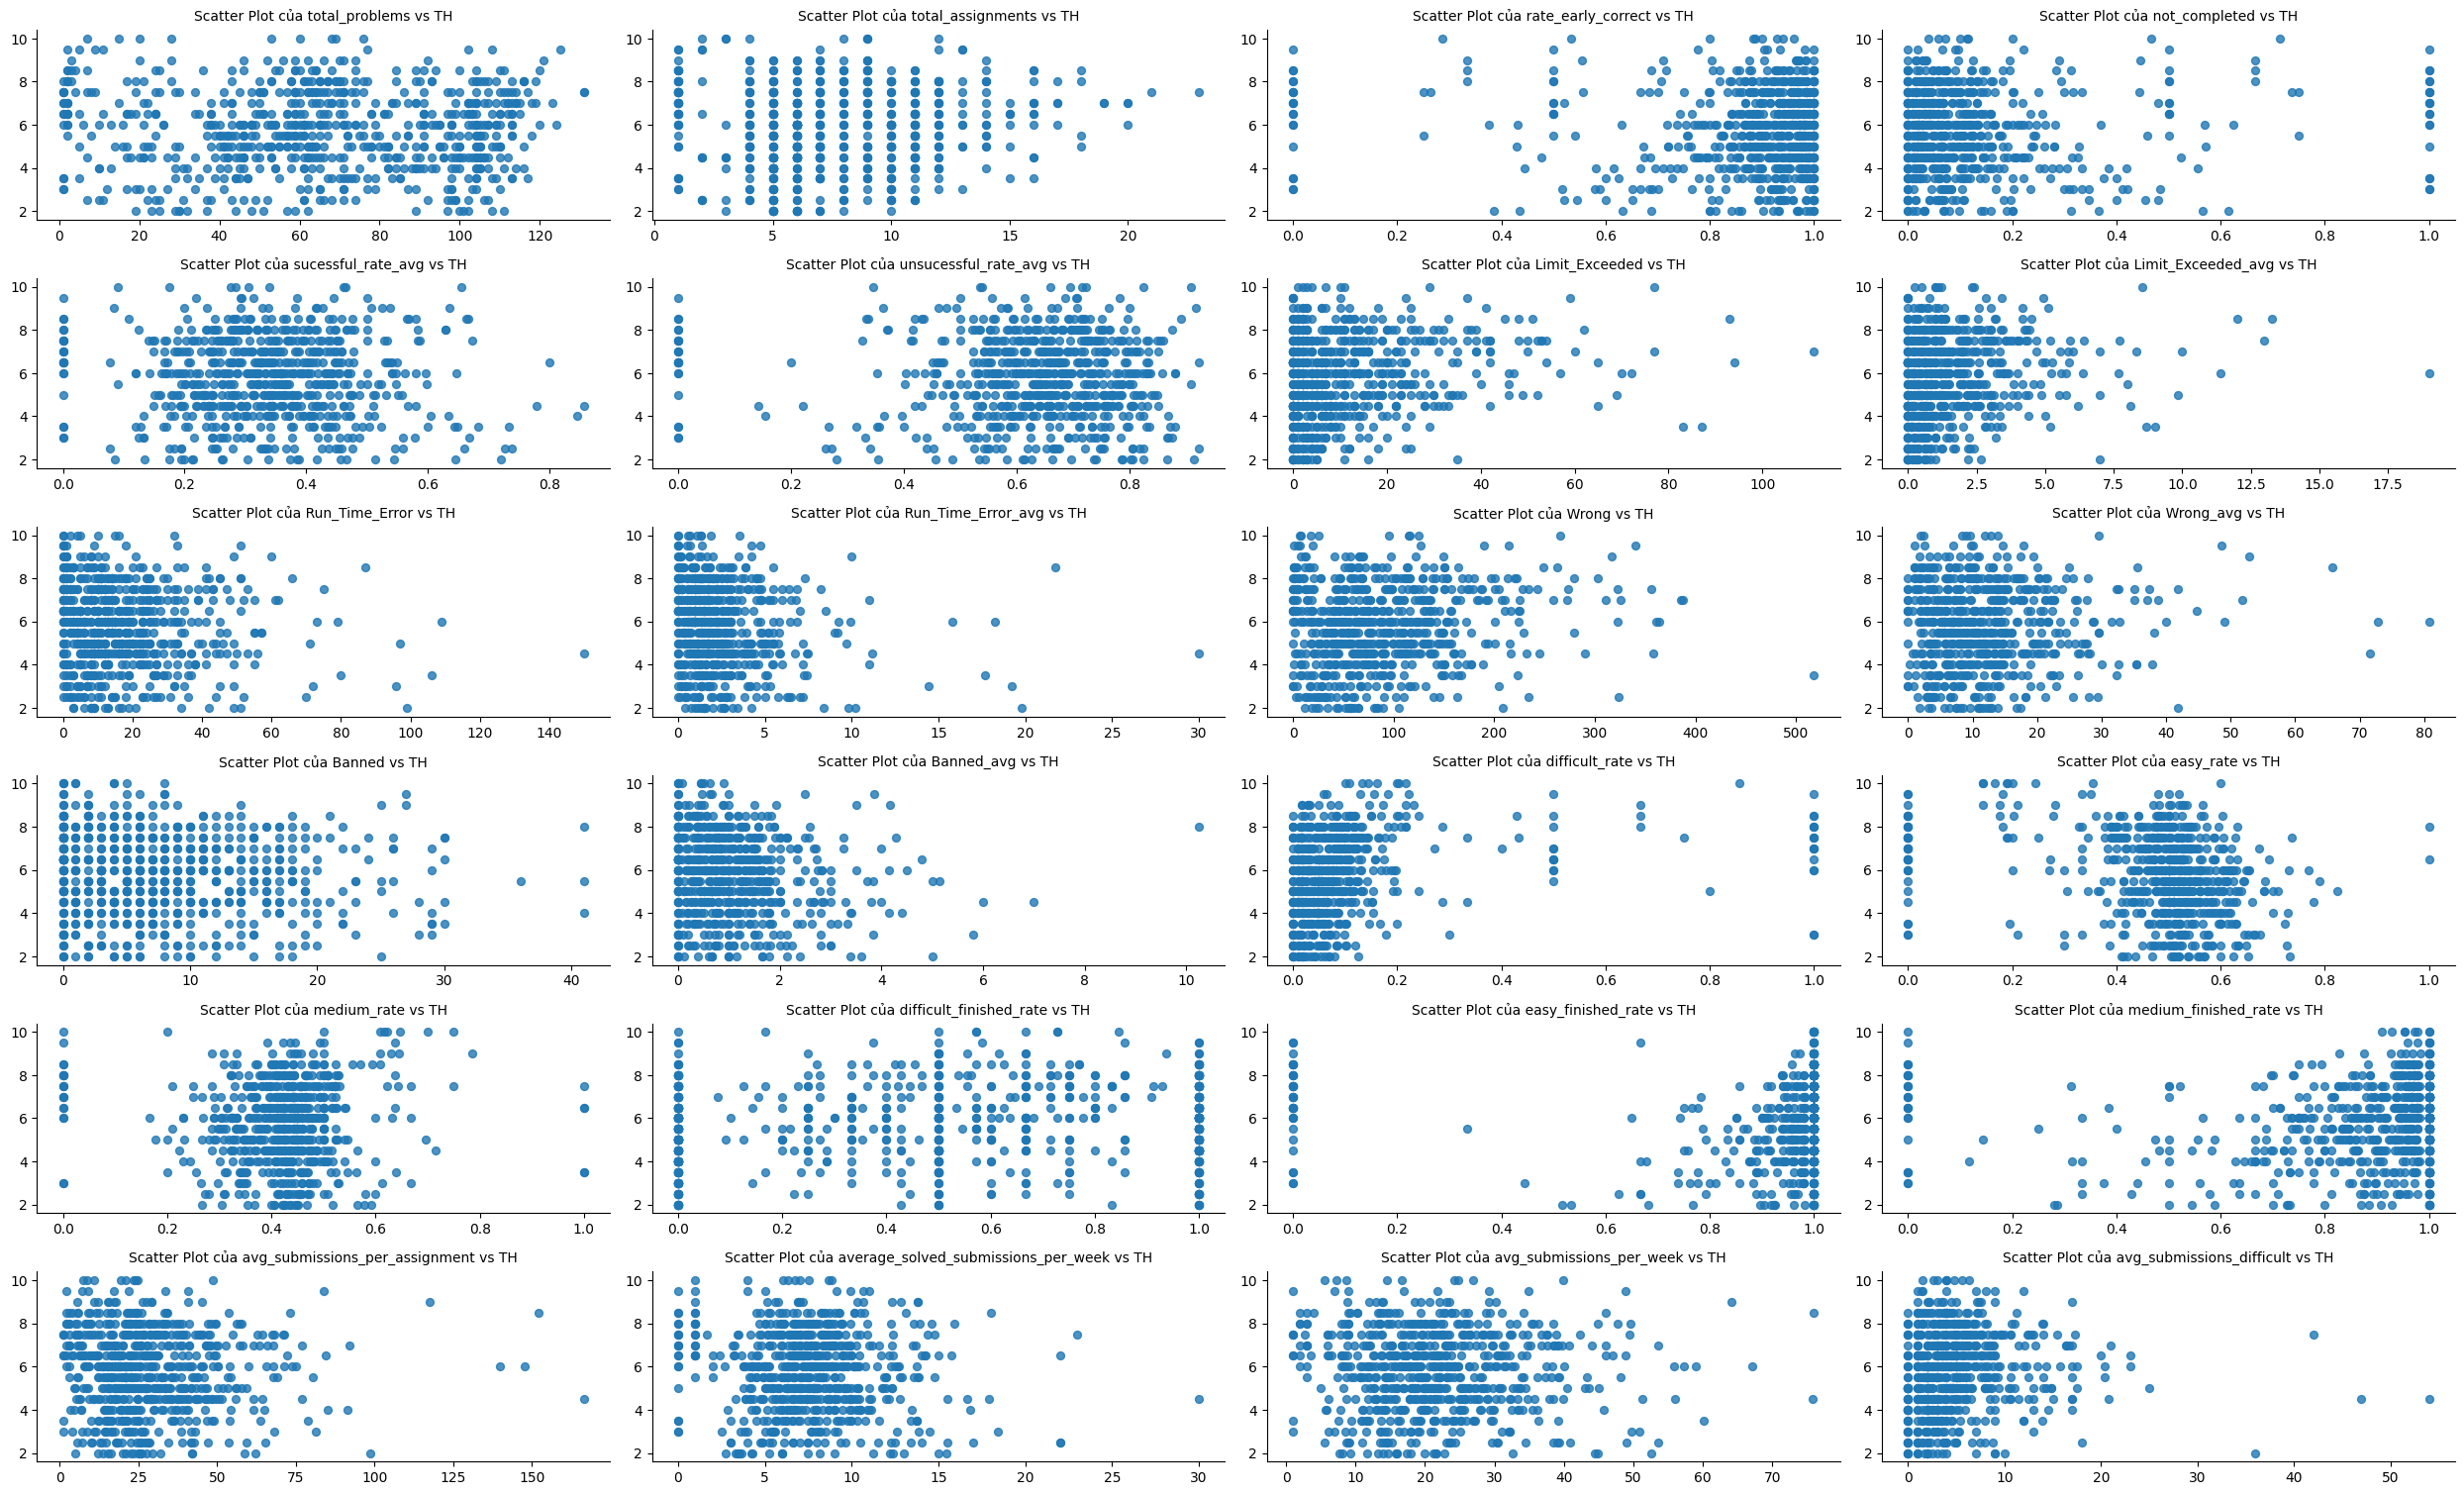

In [52]:
# Plot các scatter plot của các cột số học đối với 'CK'
fig, axs = plt.subplots(10, 4, figsize=(25, 25))  # 10 hàng, 4 cột

# Giải phóng mảng axs để dễ dàng lặp
axs = axs.flatten()

# Lặp qua các cột và tạo scatter plot
for i, column in enumerate(full_df_temp_ck_merged.columns[1:-1]):  # Lặp qua các cột ngoại trừ cột đầu tiên và cột cuối cùng
    axs[i].scatter(full_df_temp_ck_merged[column], full_df_temp_ck_merged['CK'], s=32, alpha=0.8)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(f'Scatter Plot của {column} vs TH', size=10)

# Xóa các subplot trống
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [53]:
full_df_temp_ck

username  total_problems  \
0     00b6dd4fc7eb817e03708c532016ef30ce564a61              46   
1     00bef8afee8f3c595d535c9c03c490cac1a4f021              78   
2     01122b3ef7e59b84189e65985305f575d6bdf83c              66   
3     0134f9f410c65ad0e8c2254a7e9288670e02a183              47   
4     013de369c439ab0ead8aa7da64423aa395a8be39              52   
...                                        ...             ...   
1484  feb8a2859a011c59efd22ed419cb69288fe03627              34   
1485  fef4a3263ed9a8ab14d457694bb8fd86ccd98312              77   
1486  ff12d6e2ab80696ed8e22fbe5497e96c68d29076             100   
1487  ff3fa2ec64294f37ae968159f810ebeda7966c51              34   
1488  ffe872165621d735a48bb5db0c71dd5195cba359              96   

      total_assignments  rate_early_correct  not_completed  \
0                     7            1.000000       0.000000   
1                     9            0.923077       0.076923   
2                     7            0.878788       0.121212   
3                     4            1.000000       0.000000   
4                     8            0.846154       0.153846   
...                 ...                 ...            ...   
1484                  9            1.000000       0.000000   
1485                  6            0.961039       0.038961   
1486                  6            0.990000       0.010000   
1487                  7            0.882353       0.117647   
1488                 10            1.000000       0.000000   

      sucessful_rate_avg  unsucessful_rate_avg  Limit_Exceeded  \
0               0.367347              0.632653               6   
1               0.328185              0.671815               5   
2               0.302564              0.697436              18   
3               0.520000              0.480000               1   
4               0.551402              0.448598               6   
...                  ...                   ...             ...   
1484            0.540541              0.459459               0   
1485            0.307692              0.692308               1   
1486            0.240275              0.759725              22   
1487            0.319149              0.680851               7   
1488            0.345865              0.654135              26   

      Limit_Exceeded_avg  Run_Time_Error  ...  difficult_rate  easy_rate  \
0               0.857143              16  ...        0.108696   0.413043   
1               0.555556              23  ...        0.064103   0.500000   
2               2.571429              12  ...        0.151515   0.409091   
3               0.250000              14  ...        0.021277   0.680851   
4               0.750000               9  ...        0.153846   0.519231   
...                  ...             ...  ...             ...        ...   
1484            0.000000               3  ...        0.058824   0.588235   
1485            0.166667              14  ...        0.025974   0.506494   
1486            3.666667              18  ...        0.030000   0.540000   
1487            1.000000               9  ...        0.088235   0.470588   
1488            2.600000              15  ...        0.010417   0.541667   

      medium_rate  difficult_finished_rate  easy_finished_rate  \
0        0.478261                 1.000000            1.000000   
1        0.435897                 0.400000            0.974359   
2        0.439394                 0.500000            1.000000   
3        0.297872                 1.000000            1.000000   
4        0.326923                 0.125000            1.000000   
...           ...                      ...                 ...   
1484     0.352941                 1.000000            1.000000   
1485     0.467532                 0.500000            1.000000   
1486     0.430000                 0.666667            1.000000   
1487     0.441176                 0.333333            1.000000   
1488     0.447917                 1.000000            1.000000   

 

# 5. Xử lý missing values và scale data

## 5.1. QT

In [54]:
# Lựa chọn các cột kiểu dữ liệu phân loại (categorical) từ DataFrame, ngoại trừ cột "username"
categorical_columns_df_qt = full_df_temp_qt.select_dtypes(include=['object']).drop(["username"], axis=1).columns

# Lựa chọn các cột kiểu dữ liệu số (numerical) từ DataFrame
numerical_columns_df_qt = full_df_temp_qt.select_dtypes(np.number).columns

In [55]:
categorical_columns_df_qt

Index([], dtype='object')

In [56]:
numerical_columns_df_qt

Index(['total_problems', 'total_assignments', 'rate_early_correct',
       'not_completed', 'sucessful_rate_avg', 'unsucessful_rate_avg',
       'Limit_Exceeded', 'Limit_Exceeded_avg', 'Run_Time_Error',
       'Run_Time_Error_avg', 'Wrong', 'Wrong_avg', 'Banned', 'Banned_avg',
       'difficult_rate', 'easy_rate', 'medium_rate', 'difficult_finished_rate',
       'easy_finished_rate', 'medium_finished_rate',
       'avg_submissions_per_assignment', 'average_solved_submissions_per_week',
       'avg_submissions_per_week', 'avg_submissions_difficult'],
      dtype='object')

In [57]:
columns_qt = categorical_columns_df_qt.tolist() + numerical_columns_df_qt.tolist() + ['username']
columns_qt

['total_problems',
 'total_assignments',
 'rate_early_correct',
 'not_completed',
 'sucessful_rate_avg',
 'unsucessful_rate_avg',
 'Limit_Exceeded',
 'Limit_Exceeded_avg',
 'Run_Time_Error',
 'Run_Time_Error_avg',
 'Wrong',
 'Wrong_avg',
 'Banned',
 'Banned_avg',
 'difficult_rate',
 'easy_rate',
 'medium_rate',
 'difficult_finished_rate',
 'easy_finished_rate',
 'medium_finished_rate',
 'avg_submissions_per_assignment',
 'average_solved_submissions_per_week',
 'avg_submissions_per_week',
 'avg_submissions_difficult',
 'username']

In [58]:
# Định nghĩa bộ xử lý cho các cột số
numerical_transformer_qt = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Điền giá trị missing bằng 0
    ('scaler', RobustScaler())  # Chuẩn hóa các giá trị số
])

In [59]:
# Định nghĩa bộ xử lý cho các cột phân loại
categorical_transformer_qt = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Điền giá trị missing bằng 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode các giá trị phân loại
])

In [60]:
# Kết hợp các bộ xử lý số và phân loại vào một bộ xử lý cột tổng hợp
preprocessor_df_qt = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_qt, numerical_columns_df_qt),  # Áp dụng bộ xử lý số
        ('cat', categorical_transformer_qt, categorical_columns_df_qt)  # Áp dụng bộ xử lý phân loại
    ],
    remainder='passthrough'  # Giữ nguyên các cột không được chỉ định trong num hoặc cat transformers
)

In [61]:
# Tạo Pipeline kết hợp các bước tiền xử lý
pipeline_df_qt = Pipeline(steps=[
    ('preprocessor', preprocessor_df_qt)  # Áp dụng bộ tiền xử lý
])

In [62]:
# Áp dụng pipeline tiền xử lý lên DataFrame
X_qt = full_df_temp_qt
X_preprocessed_qt = pipeline_df_qt.fit_transform(X_qt)

In [63]:

df_temp_1_qt = pd.DataFrame(X_preprocessed_qt, columns=columns_qt)


## 5.2. TH

In [64]:
# Lựa chọn các cột kiểu dữ liệu phân loại (categorical) từ DataFrame, ngoại trừ cột "username"
categorical_columns_df_th = full_df_temp_th.select_dtypes(include=['object']).drop(["username"], axis=1).columns

# Lựa chọn các cột kiểu dữ liệu số (numerical) từ DataFrame
numerical_columns_df_th = full_df_temp_th.select_dtypes(np.number).columns

In [65]:
categorical_columns_df_th

Index([], dtype='object')

In [66]:
numerical_columns_df_th

Index(['total_problems', 'total_assignments', 'rate_early_correct',
       'not_completed', 'sucessful_rate_avg', 'unsucessful_rate_avg',
       'Limit_Exceeded', 'Limit_Exceeded_avg', 'Run_Time_Error',
       'Run_Time_Error_avg', 'Wrong', 'Wrong_avg', 'Banned', 'Banned_avg',
       'difficult_rate', 'easy_rate', 'medium_rate', 'difficult_finished_rate',
       'easy_finished_rate', 'medium_finished_rate',
       'avg_submissions_per_assignment', 'average_solved_submissions_per_week',
       'avg_submissions_per_week', 'avg_submissions_difficult'],
      dtype='object')

In [67]:
columns_th = categorical_columns_df_th.tolist() + numerical_columns_df_th.tolist() + ['username']
columns_th

['total_problems',
 'total_assignments',
 'rate_early_correct',
 'not_completed',
 'sucessful_rate_avg',
 'unsucessful_rate_avg',
 'Limit_Exceeded',
 'Limit_Exceeded_avg',
 'Run_Time_Error',
 'Run_Time_Error_avg',
 'Wrong',
 'Wrong_avg',
 'Banned',
 'Banned_avg',
 'difficult_rate',
 'easy_rate',
 'medium_rate',
 'difficult_finished_rate',
 'easy_finished_rate',
 'medium_finished_rate',
 'avg_submissions_per_assignment',
 'average_solved_submissions_per_week',
 'avg_submissions_per_week',
 'avg_submissions_difficult',
 'username']

In [68]:
# Định nghĩa bộ xử lý cho các cột số
numerical_transformer_th = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Điền giá trị missing bằng 0
    ('scaler', RobustScaler())  # Chuẩn hóa các giá trị số
])

In [69]:
# Định nghĩa bộ xử lý cho các cột phân loại
categorical_transformer_th = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Điền giá trị missing bằng 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode các giá trị phân loại
])

In [70]:
# Kết hợp các bộ xử lý số và phân loại vào một bộ xử lý cột tổng hợp
preprocessor_df_th = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_th, numerical_columns_df_th),  # Áp dụng bộ xử lý số
        ('cat', categorical_transformer_th, categorical_columns_df_th)  # Áp dụng bộ xử lý phân loại
    ],
    remainder='passthrough'  # Giữ nguyên các cột không được chỉ định trong num hoặc cat transformers
)

In [71]:
# Tạo Pipeline kết hợp các bước tiền xử lý
pipeline_df_th = Pipeline(steps=[
    ('preprocessor', preprocessor_df_th)  # Áp dụng bộ tiền xử lý
])

In [72]:
# Áp dụng pipeline tiền xử lý lên DataFrame
X_th = full_df_temp_th
X_preprocessed_th = pipeline_df_th.fit_transform(X_th)

In [73]:
# Chuyển đổi dữ liệu đã tiền xử lý thành DataFrame và đặt tên các cột
df_temp_1_th = pd.DataFrame(X_preprocessed_th, columns=columns_th)

## 5.3. TBTL

In [74]:
# Lựa chọn các cột kiểu dữ liệu phân loại (categorical) từ DataFrame, ngoại trừ cột "username"
categorical_columns_df_tbtl = full_df_temp_tbtl.select_dtypes(include=['object']).drop(["username"], axis=1).columns

# Lựa chọn các cột kiểu dữ liệu số (numerical) từ DataFrame
numerical_columns_df_tbtl = full_df_temp_tbtl.select_dtypes(np.number).columns

In [75]:
categorical_columns_df_tbtl

Index([], dtype='object')

In [76]:
numerical_columns_df_tbtl

Index(['total_problems', 'total_assignments', 'rate_early_correct',
       'not_completed', 'sucessful_rate_avg', 'unsucessful_rate_avg',
       'Limit_Exceeded', 'Limit_Exceeded_avg', 'Run_Time_Error',
       'Run_Time_Error_avg', 'Wrong', 'Wrong_avg', 'Banned', 'Banned_avg',
       'difficult_rate', 'easy_rate', 'medium_rate', 'difficult_finished_rate',
       'easy_finished_rate', 'medium_finished_rate',
       'avg_submissions_per_assignment', 'average_solved_submissions_per_week',
       'avg_submissions_per_week', 'avg_submissions_difficult'],
      dtype='object')

In [77]:
columns_tbtl = categorical_columns_df_tbtl.tolist() + numerical_columns_df_tbtl.tolist() + ['username']
columns_tbtl

['total_problems',
 'total_assignments',
 'rate_early_correct',
 'not_completed',
 'sucessful_rate_avg',
 'unsucessful_rate_avg',
 'Limit_Exceeded',
 'Limit_Exceeded_avg',
 'Run_Time_Error',
 'Run_Time_Error_avg',
 'Wrong',
 'Wrong_avg',
 'Banned',
 'Banned_avg',
 'difficult_rate',
 'easy_rate',
 'medium_rate',
 'difficult_finished_rate',
 'easy_finished_rate',
 'medium_finished_rate',
 'avg_submissions_per_assignment',
 'average_solved_submissions_per_week',
 'avg_submissions_per_week',
 'avg_submissions_difficult',
 'username']

In [78]:
# Định nghĩa bộ xử lý cho các cột số
numerical_transformer_tbtl = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Điền giá trị missing bằng 0
    ('scaler', RobustScaler())  # Chuẩn hóa các giá trị số
])

In [79]:
# Định nghĩa bộ xử lý cho các cột phân loại
categorical_transformer_tbtl = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Điền giá trị missing bằng 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode các giá trị phân loại
])

In [80]:
# Kết hợp các bộ xử lý số và phân loại vào một bộ xử lý cột tổng hợp
preprocessor_df_tbtl = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_tbtl, numerical_columns_df_tbtl),  # Áp dụng bộ xử lý số
        ('cat', categorical_transformer_tbtl, categorical_columns_df_tbtl)  # Áp dụng bộ xử lý phân loại
    ],
    remainder='passthrough'  # Giữ nguyên các cột không được chỉ định trong num hoặc cat transformers
)

In [81]:
# Tạo Pipeline kết hợp các bước tiền xử lý
pipeline_df_tbtl = Pipeline(steps=[
    ('preprocessor', preprocessor_df_tbtl)  # Áp dụng bộ tiền xử lý
])

In [82]:
# Áp dụng pipeline tiền xử lý lên DataFrame
X_tbtl = full_df_temp_tbtl
X_preprocessed_tbtl = pipeline_df_tbtl.fit_transform(X_tbtl)

In [83]:
# Chuyển đổi dữ liệu đã tiền xử lý thành DataFrame và đặt tên các cột
df_temp_1_tbtl = pd.DataFrame(X_preprocessed_tbtl, columns = columns_tbtl)

## 5.4. CK

In [84]:
# Lựa chọn các cột kiểu dữ liệu phân loại (categorical) từ DataFrame, ngoại trừ cột "username"
categorical_columns_df_ck = full_df_temp_ck.select_dtypes(include=['object']).drop(["username"], axis=1).columns

# Lựa chọn các cột kiểu dữ liệu số (numerical) từ DataFrame
numerical_columns_df_ck = full_df_temp_ck.select_dtypes(np.number).columns

In [85]:
categorical_columns_df_ck

Index([], dtype='object')

In [86]:
numerical_columns_df_ck

Index(['total_problems', 'total_assignments', 'rate_early_correct',
       'not_completed', 'sucessful_rate_avg', 'unsucessful_rate_avg',
       'Limit_Exceeded', 'Limit_Exceeded_avg', 'Run_Time_Error',
       'Run_Time_Error_avg', 'Wrong', 'Wrong_avg', 'Banned', 'Banned_avg',
       'difficult_rate', 'easy_rate', 'medium_rate', 'difficult_finished_rate',
       'easy_finished_rate', 'medium_finished_rate',
       'avg_submissions_per_assignment', 'average_solved_submissions_per_week',
       'avg_submissions_per_week', 'avg_submissions_difficult'],
      dtype='object')

In [87]:
columns_ck = categorical_columns_df_ck.tolist() + numerical_columns_df_ck.tolist() + ['username']
columns_ck

['total_problems',
 'total_assignments',
 'rate_early_correct',
 'not_completed',
 'sucessful_rate_avg',
 'unsucessful_rate_avg',
 'Limit_Exceeded',
 'Limit_Exceeded_avg',
 'Run_Time_Error',
 'Run_Time_Error_avg',
 'Wrong',
 'Wrong_avg',
 'Banned',
 'Banned_avg',
 'difficult_rate',
 'easy_rate',
 'medium_rate',
 'difficult_finished_rate',
 'easy_finished_rate',
 'medium_finished_rate',
 'avg_submissions_per_assignment',
 'average_solved_submissions_per_week',
 'avg_submissions_per_week',
 'avg_submissions_difficult',
 'username']

In [88]:
# Định nghĩa bộ xử lý cho các cột số
numerical_transformer_ck = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Điền giá trị missing bằng 0
    ('scaler', RobustScaler())  # Chuẩn hóa các giá trị số
])

In [89]:
# Định nghĩa bộ xử lý cho các cột phân loại
categorical_transformer_ck = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Điền giá trị missing bằng 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode các giá trị phân loại
])

In [90]:
# Kết hợp các bộ xử lý số và phân loại vào một bộ xử lý cột tổng hợp
preprocessor_df_ck = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_ck, numerical_columns_df_ck),  # Áp dụng bộ xử lý số
        ('cat', categorical_transformer_ck, categorical_columns_df_ck)  # Áp dụng bộ xử lý phân loại
    ],
    remainder='passthrough'  # Giữ nguyên các cột không được chỉ định trong num hoặc cat transformers
)

In [91]:
# Tạo Pipeline kết hợp các bước tiền xử lý
pipeline_df_ck = Pipeline(steps=[
    ('preprocessor', preprocessor_df_ck)  # Áp dụng bộ tiền xử lý
])

In [92]:
# Áp dụng pipeline tiền xử lý lên DataFrame
X_ck = full_df_temp_ck
X_preprocessed_ck = pipeline_df_ck.fit_transform(X_ck)

In [93]:
# Chuyển đổi dữ liệu đã tiền xử lý thành DataFrame và đặt tên các cột
df_temp_1_ck = pd.DataFrame(X_preprocessed_ck, columns=columns_ck)

# 6. Chuẩn bị dữ liệu cho việc huấn luyện mô hình và dự đoán

## 6.1. QT

In [94]:
full_df_qt = pd.merge(df_temp_1_qt, df_qt, left_on='username', right_on='hash', how='left')

In [95]:
public_df_qt = full_df_qt[full_df_qt['username'].isin(df_qt['hash'])]

In [96]:
# Chuyển đổi cột 'diemqt' sang kiểu số, các giá trị không phải số sẽ thành NaN
public_df_qt['diemqt'] = pd.to_numeric(public_df_qt['diemqt'], errors='coerce')

# Điền các giá trị NaN bằng 0 (hoặc giá trị mặc định khác nếu bạn muốn)
public_df_qt.fillna(0, inplace=True)

<ipython-input-96-ffc2ec637479>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_df_qt['diemqt'] = pd.to_numeric(public_df_qt['diemqt'], errors='coerce')
<ipython-input-96-ffc2ec637479>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_df_qt.fillna(0, inplace=True)


In [97]:
public_df_qt

total_problems total_assignments rate_early_correct not_completed  \
0        -0.307692               0.2           0.561702     -0.561702   
1         0.307692               0.6          -0.086416      0.086416   
2         0.076923               0.2          -0.459574      0.459574   
4        -0.192308               0.4          -0.734534      0.734534   
5         0.538462               0.6          -0.468085      0.468085   
..             ...               ...                ...           ...   
796      -0.365385               0.0          -0.222068      0.222068   
797       0.807692               2.2           0.399673     -0.399673   
798      -0.192308               0.4          -0.248445      0.248445   
799            1.0               1.2           0.192161     -0.192161   
800      -0.730769              -0.4           0.210638     -0.210638   

    sucessful_rate_avg unsucessful_rate_avg Limit_Exceeded Limit_Exceeded_avg  \
0             0.164188            -0.114539            0.0          -0.029685   
1            -0.068338             0.115243      -0.076923           -0.20202   
2            -0.220466             0.265576       0.923077           0.949907   
4             1.257033            -1.194485            0.0          -0.090909   
5             0.340167             -0.28844      -0.461538          -0.519481   
..                 ...                  ...            ...                ...   
796           0.176197            -0.126406      -0.307692          -0.329004   
797          -0.220722             0.265828       0.076923          -0.284186   
798          -0.216537             0.261693      -0.307692          -0.376623   
799          -0.812395             0.850518       1.307692           0.575758   
800           0.512007            -0.458252      -0.461538          -0.519481   

    Run_Time_Error Run_Time_Error_avg  ... difficult_finished_rate  \
0         0.166667           0.223972  ...                0.555556   
1         0.555556           0.342957  ...               -0.111111   
2        -0.055556          -0.027997  ...                     0.0   
4        -0.222222          -0.287839  ...               -0.416667   
5         0.388889           0.195976  ...               -0.238095   
..             ...                ...  ...                     ...   
796       0.166667           0.391951  ...                     0.0   
797       1.444444           0.227677  ...                0.308642   
798       0.277778           0.208224  ...               -0.555556   
799       2.722222           1.494313  ...               -0.061728   
800      -0.277778           0.097988  ...               -0.555556   

    easy_finished_rate medium_finished_rate avg_submissions_per_assignment  \
0                  0.0             0.333333                      -0.160643   
1            -0.602564            -0.039216                        0.21419   
2                  0.0            -0.321839                       0.169822   
4                  0.0            -0.039216                      -0.528112   
5            -1.382353            -0.260417                      -0.107095   
..                 ...                  ...                            ...   
796                0.0            -0.666667                      -0.281124   
797                0.0             0.333333                      -0.160643   
798          -2.203125                  0.0                      -0.238956   
799                0.0             0.333333                       1.064257   
800                0.0                 -0.3                      -0.522088   

    average_solved_submissions_per_week avg_submissions_per_week  \
0                             -0.549202                -0.423516   
1                               0.30866                 0.126522   
2                             -0.229425                -0.181611   
4                              1.221867                 0.111872   
5                              0.689

In [98]:
# private_df = full_df[~full_df['username'].isin(public_df['username'])]
private_df_qt = full_df_qt[~full_df_qt['username'].isin(df_qt['hash'])]

In [99]:
private_df_qt

total_problems total_assignments rate_early_correct not_completed  \
3         -0.288462              -0.4           0.561702     -0.561702   
20        -0.230769              -0.4           0.561702     -0.561702   
68        -0.230769              -0.4           0.561702     -0.561702   
80         0.057692               0.0           0.172831     -0.172831   
120        0.038462              -0.2           0.430053     -0.430053   
...             ...               ...                ...           ...   
1484      -0.538462               0.6           0.561702     -0.561702   
1485       0.288462               0.0           0.233435     -0.233435   
1486       0.730769               0.0           0.477447     -0.477447   
1487      -0.538462               0.2          -0.429537      0.429537   
1488       0.653846               0.8           0.561702     -0.561702   

     sucessful_rate_avg unsucessful_rate_avg Limit_Exceeded  \
3              1.070581            -1.010234      -0.384615   
20             0.127162             -0.07795      -0.461538   
68            -0.377946             0.421197       0.076923   
80             0.340167             -0.28844       0.307692   
120            0.626219            -0.571116      -0.307692   
...                 ...                  ...            ...   
1484           1.192542            -1.130756      -0.461538   
1485          -0.190017             0.235486      -0.384615   
1486          -0.590316             0.631061       1.230769   
1487          -0.121992             0.168264       0.076923   
1488           0.036635             0.011509       1.538462   

     Limit_Exceeded_avg Run_Time_Error Run_Time_Error_avg  ...  \
3             -0.376623       0.055556           0.759405  ...   
20            -0.519481       0.333333           1.310586  ...   
68             0.480519       0.277778            1.20035  ...   
80               0.4329      -0.055556           0.097988  ...   
120           -0.290909      -0.166667           0.097988  ...   
...                 ...            ...                ...  ...   
1484          -0.519481      -0.555556           -0.63692  ...   
1485          -0.424242       0.055556           0.244969  ...   
1486           1.575758       0.277778           0.538933  ...   
1487           0.051948      -0.222222          -0.216973  ...   
1488           0.966234       0.111111          -0.122485  ...   

     difficult_finished_rate easy_finished_rate medium_finished_rate  \
3                   0.555556                0.0             0.333333   
20                  0.555556                0.0             0.333333   
68                  0.555556                0.0             0.333333   
80                  0.111111                0.0             0.057971   
120                 0.555556          -0.522222             0.333333   
...                      ...                ...                  ...   
1484                0.555556                0.0             0.333333   
1485                     0.0                0.0            -0.018519   
1486                0.185185                0.0             0.333333   
1487               -0.185185                0.0            -0.511111   
1488                0.555556                0.0             0.333333   

     avg_submissions_per_assignment average_solved_submissions_per_week  \
3                          0.032129                            0.354781   
20                         0.562249                            1.553943   
68                         1.140562                            0.889792   
80                         0.425703                            1.600065   
120                        0.321285                            1.775327   
...                             ...                                 ...   
1484                      -0.776439                            0.170295   
1485                       0.915663                            0.723754   
1486                      

In [100]:
public_df_qt = public_df_qt[public_df_qt['diemqt'] >= 5.5]

In [101]:
X_train_qt = public_df_qt.iloc[:, 0:-3].values
y_train_qt = public_df_qt.iloc[:, -1].values

## 6.2. TH

In [102]:
full_df_th = pd.merge(df_temp_1_th, df_th, left_on='username', right_on='hash', how='left')

In [103]:
public_df_th = full_df_th[full_df_th['username'].isin(df_th['hash'])]


In [104]:
# Chuyển đổi cột 'TH' sang kiểu số, các giá trị không phải số sẽ thành NaN
public_df_th['TH'] = pd.to_numeric(public_df_th['TH'], errors='coerce')

# Điền các giá trị NaN bằng 0 (hoặc giá trị mặc định khác nếu bạn muốn)
public_df_th.fillna(0, inplace=True)

<ipython-input-104-d1cd6dcc80a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_df_th['TH'] = pd.to_numeric(public_df_th['TH'], errors='coerce')
<ipython-input-104-d1cd6dcc80a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_df_th.fillna(0, inplace=True)


In [105]:
# private_df = full_df[~full_df['username'].isin(public_df['username'])]
private_df_th = full_df_th[~full_df_th['username'].isin(df_th['hash'])]
private_df_th

total_problems total_assignments rate_early_correct not_completed  \
3         -0.288462              -0.4           0.561702     -0.561702   
20        -0.230769              -0.4           0.561702     -0.561702   
68        -0.230769              -0.4           0.561702     -0.561702   
80         0.057692               0.0           0.172831     -0.172831   
120        0.038462              -0.2           0.430053     -0.430053   
...             ...               ...                ...           ...   
1484      -0.538462               0.6           0.561702     -0.561702   
1485       0.288462               0.0           0.233435     -0.233435   
1486       0.730769               0.0           0.477447     -0.477447   
1487      -0.538462               0.2          -0.429537      0.429537   
1488       0.653846               0.8           0.561702     -0.561702   

     sucessful_rate_avg unsucessful_rate_avg Limit_Exceeded  \
3              1.070581            -1.010234      -0.384615   
20             0.127162             -0.07795      -0.461538   
68            -0.377946             0.421197       0.076923   
80             0.340167             -0.28844       0.307692   
120            0.626219            -0.571116      -0.307692   
...                 ...                  ...            ...   
1484           1.192542            -1.130756      -0.461538   
1485          -0.190017             0.235486      -0.384615   
1486          -0.590316             0.631061       1.230769   
1487          -0.121992             0.168264       0.076923   
1488           0.036635             0.011509       1.538462   

     Limit_Exceeded_avg Run_Time_Error Run_Time_Error_avg  ...  \
3             -0.376623       0.055556           0.759405  ...   
20            -0.519481       0.333333           1.310586  ...   
68             0.480519       0.277778            1.20035  ...   
80               0.4329      -0.055556           0.097988  ...   
120           -0.290909      -0.166667           0.097988  ...   
...                 ...            ...                ...  ...   
1484          -0.519481      -0.555556           -0.63692  ...   
1485          -0.424242       0.055556           0.244969  ...   
1486           1.575758       0.277778           0.538933  ...   
1487           0.051948      -0.222222          -0.216973  ...   
1488           0.966234       0.111111          -0.122485  ...   

     difficult_finished_rate easy_finished_rate medium_finished_rate  \
3                   0.555556                0.0             0.333333   
20                  0.555556                0.0             0.333333   
68                  0.555556                0.0             0.333333   
80                  0.111111                0.0             0.057971   
120                 0.555556          -0.522222             0.333333   
...                      ...                ...                  ...   
1484                0.555556                0.0             0.333333   
1485                     0.0                0.0            -0.018519   
1486                0.185185                0.0             0.333333   
1487               -0.185185                0.0            -0.511111   
1488                0.555556                0.0             0.333333   

     avg_submissions_per_assignment average_solved_submissions_per_week  \
3                          0.032129                            0.354781   
20                         0.562249                            1.553943   
68                         1.140562                            0.889792   
80                         0.425703                            1.600065   
120                        0.321285                            1.775327   
...                             ...                                 ...   
1484                      -0.776439                            0.170295   
1485                       0.915663                            0.723754   
1486                      

In [106]:
X_train_th = public_df_th.iloc[:, 0:-3].values
y_train_th = public_df_th.iloc[:, -1].values

## 6.3. TBTL

In [107]:
full_df_tbtl = pd.merge(df_temp_1_tbtl, df_tbtl, on='username', how='left')

In [108]:
public_df_tbtl = full_df_tbtl[full_df_tbtl['username'].isin(df_tbtl['username'])]
public_df_tbtl

total_problems total_assignments rate_early_correct not_completed  \
0        -0.307692               0.2           0.561702     -0.561702   
1         0.307692               0.6          -0.086416      0.086416   
2         0.076923               0.2          -0.459574      0.459574   
3        -0.288462              -0.4           0.561702     -0.561702   
4        -0.192308               0.4          -0.734534      0.734534   
..             ...               ...                ...           ...   
796      -0.365385               0.0          -0.222068      0.222068   
797       0.807692               2.2           0.399673     -0.399673   
798      -0.192308               0.4          -0.248445      0.248445   
799            1.0               1.2           0.192161     -0.192161   
800      -0.730769              -0.4           0.210638     -0.210638   

    sucessful_rate_avg unsucessful_rate_avg Limit_Exceeded Limit_Exceeded_avg  \
0             0.164188            -0.114539            0.0          -0.029685   
1            -0.068338             0.115243      -0.076923           -0.20202   
2            -0.220466             0.265576       0.923077           0.949907   
3             1.070581            -1.010234      -0.384615          -0.376623   
4             1.257033            -1.194485            0.0          -0.090909   
..                 ...                  ...            ...                ...   
796           0.176197            -0.126406      -0.307692          -0.329004   
797          -0.220722             0.265828       0.076923          -0.284186   
798          -0.216537             0.261693      -0.307692          -0.376623   
799          -0.812395             0.850518       1.307692           0.575758   
800           0.512007            -0.458252      -0.461538          -0.519481   

    Run_Time_Error Run_Time_Error_avg  ... medium_rate  \
0         0.166667           0.223972  ...    0.511755   
1         0.555556           0.342957  ...    0.075451   
2        -0.055556          -0.027997  ...    0.111462   
3         0.055556           0.759405  ...   -1.346078   
4        -0.222222          -0.287839  ...   -1.046883   
..             ...                ...  ...         ...   
796       0.166667           0.391951  ...    0.136865   
797       1.444444           0.227677  ...   -0.155618   
798       0.277778           0.208224  ...   -0.650765   
799       2.722222           1.494313  ...    0.374277   
800      -0.277778           0.097988  ...   -0.122608   

    difficult_finished_rate easy_finished_rate medium_finished_rate  \
0                  0.555556                0.0             0.333333   
1                 -0.111111          -0.602564            -0.039216   
2                       0.0                0.0            -0.321839   
3                  0.555556                0.0             0.333333   
4                 -0.416667                0.0            -0.039216   
..                      ...                ...                  ...   
796                     0.0                0.0            -0.666667   
797                0.308642                0.0             0.333333   
798               -0.555556          -2.203125                  0.0   
799               -0.061728                0.0             0.333333   
800               -0.555556                0.0                 -0.3   

    avg_submissions_per_assignment average_solved_submissions_per_week  \
0                        -0.160643                           -0.549202   
1                          0.21419                             0.30866   
2                         0.169822                           -0.229425   
3                         0.032129                            0.354781   
4                        -0.528112                            1.221867   
..                             ...                                 ...   
796                      -0.281124                            -0.90895   
797         

In [109]:
public_df_tbtl = public_df_tbtl[public_df_tbtl['TBTL'] >= 5]

In [110]:
private_df_tbtl = full_df_tbtl[~full_df_tbtl['username'].isin(df_tbtl['username'])]
private_df_tbtl

total_problems total_assignments rate_early_correct not_completed  \
394       -0.884615              -0.8           0.561702     -0.561702   
625       -1.153846              -1.0           -7.86383       7.86383   
801        0.692308               0.0           0.561702     -0.561702   
802        0.384615               0.2            0.04795      -0.04795   
803        0.634615               1.2           0.118253     -0.118253   
...             ...               ...                ...           ...   
1484      -0.538462               0.6           0.561702     -0.561702   
1485       0.288462               0.0           0.233435     -0.233435   
1486       0.730769               0.0           0.477447     -0.477447   
1487      -0.538462               0.2          -0.429537      0.429537   
1488       0.653846               0.8           0.561702     -0.561702   

     sucessful_rate_avg unsucessful_rate_avg Limit_Exceeded  \
394            0.330452            -0.278841      -0.461538   
625           -2.016971            -3.826644      -0.461538   
801            1.571688            -1.505427      -0.461538   
802            0.877609             -0.81954            0.0   
803           -0.536387             0.577767       0.230769   
...                 ...                  ...            ...   
1484           1.192542            -1.130756      -0.461538   
1485          -0.190017             0.235486      -0.384615   
1486          -0.590316             0.631061       1.230769   
1487          -0.121992             0.168264       0.076923   
1488           0.036635             0.011509       1.538462   

     Limit_Exceeded_avg Run_Time_Error Run_Time_Error_avg  ... medium_rate  \
394           -0.519481      -0.611111          -0.342957  ...    0.091956   
625           -0.519481      -0.444444           1.420822  ...    0.735648   
801           -0.519481      -0.222222          -0.122485  ...         0.0   
802           -0.029685       0.111111            0.16098  ...   -0.520336   
803           -0.090909       1.388889           0.612423  ...    -0.40267   
...                 ...            ...                ...  ...         ...   
1484          -0.519481      -0.555556           -0.63692  ...   -0.778921   
1485          -0.424242       0.055556           0.244969  ...    0.401262   
1486           1.575758       0.277778           0.538933  ...    0.014713   
1487           0.051948      -0.222222          -0.216973  ...     0.12982   
1488           0.966234       0.111111          -0.122485  ...    0.199238   

     difficult_finished_rate easy_finished_rate medium_finished_rate  \
394                -0.555556                0.0             0.333333   
625                -0.555556              -23.5                 -6.0   
801                 0.555556                0.0             0.333333   
802                      0.0               -0.5            -0.075269   
803                 0.111111                0.0             -0.18018   
...                      ...                ...                  ...   
1484                0.555556                0.0             0.333333   
1485                     0.0                0.0            -0.018519   
1486                0.185185                0.0             0.333333   
1487               -0.185185                0.0            -0.511111   
1488                0.555556                0.0             0.333333   

     avg_submissions_per_assignment average_solved_submissions_per_week  \
394                       -0.136546                           -0.475407   
625                       -0.787149                           -2.043541   
801                        0.289157                            0.298016   
802                       -0.071142                           -0.501762   
803                        0.389558                            0.640735   
...                             ...                                 ...   
1484                      -0.776

In [111]:
X_train_tbtl = public_df_tbtl.iloc[:, 0:-2].values
y_train_tbtl = public_df_tbtl.iloc[:, -1].values

## 6.4. CK

In [112]:
full_df_ck = pd.merge(df_temp_1_ck, df_ck, left_on='username', right_on='hash', how='left')

In [113]:
public_df_ck = full_df_ck[full_df_ck['username'].isin(df_ck['hash'])]
public_df_ck

total_problems total_assignments rate_early_correct not_completed  \
0        -0.307692               0.2           0.561702     -0.561702   
1         0.307692               0.6          -0.086416      0.086416   
2         0.076923               0.2          -0.459574      0.459574   
4        -0.192308               0.4          -0.734534      0.734534   
5         0.538462               0.6          -0.468085      0.468085   
..             ...               ...                ...           ...   
796      -0.365385               0.0          -0.222068      0.222068   
797       0.807692               2.2           0.399673     -0.399673   
798      -0.192308               0.4          -0.248445      0.248445   
799            1.0               1.2           0.192161     -0.192161   
800      -0.730769              -0.4           0.210638     -0.210638   

    sucessful_rate_avg unsucessful_rate_avg Limit_Exceeded Limit_Exceeded_avg  \
0             0.164188            -0.114539            0.0          -0.029685   
1            -0.068338             0.115243      -0.076923           -0.20202   
2            -0.220466             0.265576       0.923077           0.949907   
4             1.257033            -1.194485            0.0          -0.090909   
5             0.340167             -0.28844      -0.461538          -0.519481   
..                 ...                  ...            ...                ...   
796           0.176197            -0.126406      -0.307692          -0.329004   
797          -0.220722             0.265828       0.076923          -0.284186   
798          -0.216537             0.261693      -0.307692          -0.376623   
799          -0.812395             0.850518       1.307692           0.575758   
800           0.512007            -0.458252      -0.461538          -0.519481   

    Run_Time_Error Run_Time_Error_avg  ... difficult_finished_rate  \
0         0.166667           0.223972  ...                0.555556   
1         0.555556           0.342957  ...               -0.111111   
2        -0.055556          -0.027997  ...                     0.0   
4        -0.222222          -0.287839  ...               -0.416667   
5         0.388889           0.195976  ...               -0.238095   
..             ...                ...  ...                     ...   
796       0.166667           0.391951  ...                     0.0   
797       1.444444           0.227677  ...                0.308642   
798       0.277778           0.208224  ...               -0.555556   
799       2.722222           1.494313  ...               -0.061728   
800      -0.277778           0.097988  ...               -0.555556   

    easy_finished_rate medium_finished_rate avg_submissions_per_assignment  \
0                  0.0             0.333333                      -0.160643   
1            -0.602564            -0.039216                        0.21419   
2                  0.0            -0.321839                       0.169822   
4                  0.0            -0.039216                      -0.528112   
5            -1.382353            -0.260417                      -0.107095   
..                 ...                  ...                            ...   
796                0.0            -0.666667                      -0.281124   
797                0.0             0.333333                      -0.160643   
798          -2.203125                  0.0                      -0.238956   
799                0.0             0.333333                       1.064257   
800                0.0                 -0.3                      -0.522088   

    average_solved_submissions_per_week avg_submissions_per_week  \
0                             -0.549202                -0.423516   
1                               0.30866                 0.126522   
2                             -0.229425                -0.181611   
4                              1.221867                 0.111872   
5                              0.689

In [114]:
# Chuyển đổi cột 'CK' sang kiểu số, các giá trị không phải số sẽ thành NaN
public_df_ck['CK'] = pd.to_numeric(public_df_ck['CK'], errors='coerce')

# Điền các giá trị NaN bằng 0 (hoặc giá trị mặc định khác nếu bạn muốn)
public_df_ck.fillna(0, inplace=True)

public_df_ck = public_df_ck[public_df_ck['CK'] >= 2]

<ipython-input-114-bae173cf3c6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_df_ck['CK'] = pd.to_numeric(public_df_ck['CK'], errors='coerce')
<ipython-input-114-bae173cf3c6d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_df_ck.fillna(0, inplace=True)


In [115]:
public_df_ck

total_problems total_assignments rate_early_correct not_completed  \
0        -0.307692               0.2           0.561702     -0.561702   
1         0.307692               0.6          -0.086416      0.086416   
2         0.076923               0.2          -0.459574      0.459574   
4        -0.192308               0.4          -0.734534      0.734534   
5         0.538462               0.6          -0.468085      0.468085   
..             ...               ...                ...           ...   
796      -0.365385               0.0          -0.222068      0.222068   
797       0.807692               2.2           0.399673     -0.399673   
798      -0.192308               0.4          -0.248445      0.248445   
799            1.0               1.2           0.192161     -0.192161   
800      -0.730769              -0.4           0.210638     -0.210638   

    sucessful_rate_avg unsucessful_rate_avg Limit_Exceeded Limit_Exceeded_avg  \
0             0.164188            -0.114539            0.0          -0.029685   
1            -0.068338             0.115243      -0.076923           -0.20202   
2            -0.220466             0.265576       0.923077           0.949907   
4             1.257033            -1.194485            0.0          -0.090909   
5             0.340167             -0.28844      -0.461538          -0.519481   
..                 ...                  ...            ...                ...   
796           0.176197            -0.126406      -0.307692          -0.329004   
797          -0.220722             0.265828       0.076923          -0.284186   
798          -0.216537             0.261693      -0.307692          -0.376623   
799          -0.812395             0.850518       1.307692           0.575758   
800           0.512007            -0.458252      -0.461538          -0.519481   

    Run_Time_Error Run_Time_Error_avg  ... difficult_finished_rate  \
0         0.166667           0.223972  ...                0.555556   
1         0.555556           0.342957  ...               -0.111111   
2        -0.055556          -0.027997  ...                     0.0   
4        -0.222222          -0.287839  ...               -0.416667   
5         0.388889           0.195976  ...               -0.238095   
..             ...                ...  ...                     ...   
796       0.166667           0.391951  ...                     0.0   
797       1.444444           0.227677  ...                0.308642   
798       0.277778           0.208224  ...               -0.555556   
799       2.722222           1.494313  ...               -0.061728   
800      -0.277778           0.097988  ...               -0.555556   

    easy_finished_rate medium_finished_rate avg_submissions_per_assignment  \
0                  0.0             0.333333                      -0.160643   
1            -0.602564            -0.039216                        0.21419   
2                  0.0            -0.321839                       0.169822   
4                  0.0            -0.039216                      -0.528112   
5            -1.382353            -0.260417                      -0.107095   
..                 ...                  ...                            ...   
796                0.0            -0.666667                      -0.281124   
797                0.0             0.333333                      -0.160643   
798          -2.203125                  0.0                      -0.238956   
799                0.0             0.333333                       1.064257   
800                0.0                 -0.3                      -0.522088   

    average_solved_submissions_per_week avg_submissions_per_week  \
0                             -0.549202                -0.423516   
1                               0.30866                 0.126522   
2                             -0.229425                -0.181611   
4                              1.221867                 0.111872   
5                              0.689

In [116]:
private_df_ck = full_df_ck[~full_df_ck['username'].isin(df_ck['hash'])]
private_df_ck

total_problems total_assignments rate_early_correct not_completed  \
3         -0.288462              -0.4           0.561702     -0.561702   
20        -0.230769              -0.4           0.561702     -0.561702   
68        -0.230769              -0.4           0.561702     -0.561702   
80         0.057692               0.0           0.172831     -0.172831   
120        0.038462              -0.2           0.430053     -0.430053   
...             ...               ...                ...           ...   
1484      -0.538462               0.6           0.561702     -0.561702   
1485       0.288462               0.0           0.233435     -0.233435   
1486       0.730769               0.0           0.477447     -0.477447   
1487      -0.538462               0.2          -0.429537      0.429537   
1488       0.653846               0.8           0.561702     -0.561702   

     sucessful_rate_avg unsucessful_rate_avg Limit_Exceeded  \
3              1.070581            -1.010234      -0.384615   
20             0.127162             -0.07795      -0.461538   
68            -0.377946             0.421197       0.076923   
80             0.340167             -0.28844       0.307692   
120            0.626219            -0.571116      -0.307692   
...                 ...                  ...            ...   
1484           1.192542            -1.130756      -0.461538   
1485          -0.190017             0.235486      -0.384615   
1486          -0.590316             0.631061       1.230769   
1487          -0.121992             0.168264       0.076923   
1488           0.036635             0.011509       1.538462   

     Limit_Exceeded_avg Run_Time_Error Run_Time_Error_avg  ...  \
3             -0.376623       0.055556           0.759405  ...   
20            -0.519481       0.333333           1.310586  ...   
68             0.480519       0.277778            1.20035  ...   
80               0.4329      -0.055556           0.097988  ...   
120           -0.290909      -0.166667           0.097988  ...   
...                 ...            ...                ...  ...   
1484          -0.519481      -0.555556           -0.63692  ...   
1485          -0.424242       0.055556           0.244969  ...   
1486           1.575758       0.277778           0.538933  ...   
1487           0.051948      -0.222222          -0.216973  ...   
1488           0.966234       0.111111          -0.122485  ...   

     difficult_finished_rate easy_finished_rate medium_finished_rate  \
3                   0.555556                0.0             0.333333   
20                  0.555556                0.0             0.333333   
68                  0.555556                0.0             0.333333   
80                  0.111111                0.0             0.057971   
120                 0.555556          -0.522222             0.333333   
...                      ...                ...                  ...   
1484                0.555556                0.0             0.333333   
1485                     0.0                0.0            -0.018519   
1486                0.185185                0.0             0.333333   
1487               -0.185185                0.0            -0.511111   
1488                0.555556                0.0             0.333333   

     avg_submissions_per_assignment average_solved_submissions_per_week  \
3                          0.032129                            0.354781   
20                         0.562249                            1.553943   
68                         1.140562                            0.889792   
80                         0.425703                            1.600065   
120                        0.321285                            1.775327   
...                             ...                                 ...   
1484                      -0.776439                            0.170295   
1485                       0.915663                            0.723754   
1486                      

In [117]:
X_train_ck = public_df_ck.iloc[:, 0:-3].values
y_train_ck = public_df_ck.iloc[:, -1].values

# 7. Build Model


## 7.1 Chọn model để GridSearch

In [118]:
# Define the models
models = {
     'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'LightGBM': LGBMRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

In [119]:
# Define the hyperparameter grids for each model
param_grids = {
    'RandomForest': {
        'n_estimators': [400, 500, 700, 800, 900],
        'max_depth': [15, 20, 25],
        'min_samples_split': [5, 10, 20, 40]
    },
    'XGBoost': {
        'n_estimators': [100, 300, 400, 500],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
        'max_depth': [2, 3, 5],
    },
    'KNN': {
        'n_neighbors': [5, 8, 10, 12, 15, 20],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
        'num_leaves': [20, 30, 40]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
        'max_depth': [3, 4, 5]
    }
}

In [120]:
model = XGBRegressor(random_state=42)
model.fit(X_train_th, y_train_th)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### QT

#### Tìm siêu tham số thích hợp nhất cho model bằng cách dùng hàm GridSearchCV của sklearn.

In [121]:
# 3-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define R^2 scorer
r2_scorer = make_scorer(r2_score)

# Train and tune the models
grids_qt = {}
best_models_qt = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids_qt[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, scoring=r2_scorer, n_jobs=-1, verbose=2)
    grids_qt[model_name].fit(X_train_qt, y_train_qt)
    best_params_qt = grids_qt[model_name].best_params_
    best_score_qt = grids_qt[model_name].best_score_

    print(f'Best parameters for {model_name}: {best_params_qt}')
    print(f'Best R^2 for {model_name}: {best_score_qt}\n')

    # Save the best model
    best_models_qt[model_name] = grids_qt[model_name].best_estimator_

Training and tuning RandomForest...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 800}
Best R^2 for RandomForest: 0.23519866392959568

Training and tuning XGBoost...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
Best R^2 for XGBoost: 0.1857919030420884

Training and tuning KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'distance'}
Best R^2 for KNN: 0.09781461613789892

Training and tuning LightGBM...
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3592
[LightGBM] [Info] Number

### TH

#### Tìm siêu tham số thích hợp nhất cho model bằng cách dùng hàm GridSearchCV của sklearn.

In [122]:
# 3-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define R^2 scorer
r2_scorer = make_scorer(r2_score)

# Train and tune the models
grids_th = {}
best_models_th = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids_th[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, scoring=r2_scorer, n_jobs=-1, verbose=2)
    grids_th[model_name].fit(X_train_th, y_train_th)
    best_params_th = grids_th[model_name].best_params_
    best_score_th = grids_th[model_name].best_score_

    print(f'Best parameters for {model_name}: {best_params_th}')
    print(f'Best R^2 for {model_name}: {best_score_th}\n')

    # Save the best model
    best_models_th[model_name] = grids_th[model_name].best_estimator_

Training and tuning RandomForest...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters for RandomForest: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 700}
Best R^2 for RandomForest: 0.3667978134684213

Training and tuning XGBoost...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
Best R^2 for XGBoost: 0.3556562089101112

Training and tuning KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 12, 'weights': 'distance'}
Best R^2 for KNN: 0.302163263172342

Training and tuning LightGBM...
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3802
[LightGBM] [Info] Number of

### TBTL

#### Tìm siêu tham số thích hợp nhất cho model bằng cách dùng hàm GridSearchCV của sklearn.

In [123]:
# 3-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define R^2 scorer
r2_scorer = make_scorer(r2_score)

# Train and tune the models
grids_tbtl = {}
best_models_tbtl = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids_tbtl[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, scoring=r2_scorer, n_jobs=-1, verbose=2)
    grids_tbtl[model_name].fit(X_train_tbtl, y_train_tbtl)
    best_params_tbtl = grids_tbtl[model_name].best_params_
    best_score_tbtl = grids_tbtl[model_name].best_score_

    print(f'Best parameters for {model_name}: {best_params_tbtl}')
    print(f'Best R^2 for {model_name}: {best_score_tbtl}\n')

    # Save the best model
    best_models_tbtl[model_name] = grids_tbtl[model_name].best_estimator_

Training and tuning RandomForest...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters for RandomForest: {'max_depth': 15, 'min_samples_split': 40, 'n_estimators': 400}
Best R^2 for RandomForest: 0.16771543296291286

Training and tuning XGBoost...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 400}
Best R^2 for XGBoost: 0.17458999608008519

Training and tuning KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'uniform'}
Best R^2 for KNN: 0.16612326528768334

Training and tuning LightGBM...
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3857
[LightGBM] [Info] Number

### CK

#### Tìm siêu tham số thích hợp nhất cho model bằng cách dùng hàm GridSearchCV của sklearn.

In [124]:
# 3-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define R^2 scorer
r2_scorer = make_scorer(r2_score)

# Train and tune the models
grids_ck = {}
best_models_ck = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids_ck[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, scoring=r2_scorer, n_jobs=-1, verbose=2)
    grids_ck[model_name].fit(X_train_ck, y_train_ck)
    best_params_ck = grids_ck[model_name].best_params_
    best_score_ck = grids_ck[model_name].best_score_

    print(f'Best parameters for {model_name}: {best_params_ck}')
    print(f'Best R^2 for {model_name}: {best_score_ck}\n')

    # Save the best model
    best_models_ck[model_name] = grids_ck[model_name].best_estimator_

Training and tuning RandomForest...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 400}
Best R^2 for RandomForest: 0.24319242468207683

Training and tuning XGBoost...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best R^2 for XGBoost: 0.2381008235919702

Training and tuning KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for KNN: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'weights': 'distance'}
Best R^2 for KNN: 0.211545954092531

Training and tuning LightGBM...
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3607
[LightGBM] [Info] Numbe

# Prediction

### QT

In [125]:
y_pred_qt = []
X_private_qt = private_df_qt.iloc[:, 0:-3].values
for i in grids_qt.keys():
    y_pred_qt.append(grids_qt[i].predict(X_private_qt))

In [126]:
private_df_qt.columns

Index(['total_problems', 'total_assignments', 'rate_early_correct',
       'not_completed', 'sucessful_rate_avg', 'unsucessful_rate_avg',
       'Limit_Exceeded', 'Limit_Exceeded_avg', 'Run_Time_Error',
       'Run_Time_Error_avg', 'Wrong', 'Wrong_avg', 'Banned', 'Banned_avg',
       'difficult_rate', 'easy_rate', 'medium_rate', 'difficult_finished_rate',
       'easy_finished_rate', 'medium_finished_rate',
       'avg_submissions_per_assignment', 'average_solved_submissions_per_week',
       'avg_submissions_per_week', 'avg_submissions_difficult', 'username',
       'hash', 'diemqt'],
      dtype='object')

In [127]:
grids_qt.keys()

dict_keys(['RandomForest', 'XGBoost', 'KNN', 'LightGBM', 'GradientBoosting'])

In [128]:
y_pred_qt

[array([8.76881254, 8.34280158, 8.07969942, 8.41144735, 7.96246946,
        8.32552616, 8.27330214, 7.74491305, 8.34031802, 8.15141236,
        8.52024793, 8.76053448, 8.98257382, 9.07274057, 8.5674963 ,
        8.3234029 , 9.02298754, 8.54222032, 8.77023569, 8.80817588,
        8.97233347, 7.86799207, 8.95500991, 8.61514581, 8.1912049 ,
        8.21542047, 8.24789838, 8.11366364, 8.28873633, 9.67490156,
        8.69165217, 8.51950685, 8.81429597, 8.61056244, 9.28677005,
        8.05985517, 8.26212639, 8.71327661, 8.61004812, 8.64983845,
        7.78297324, 8.19754587, 8.23571561, 7.04846124, 9.32194428,
        9.36245857, 8.32271844, 8.83696139, 8.5892648 , 8.85494862,
        8.1921537 , 9.20404611, 8.98813798, 8.57774471, 8.4609915 ,
        9.42068829, 8.51542411, 8.70474663, 8.99663874, 8.69514913,
        8.88547702, 8.57427126, 6.67652807, 6.97185091, 8.38611534,
        8.74782004, 8.98538312, 8.83596344, 8.04965373, 8.88136501,
        8.7262365 , 8.1442259 , 8.96067462, 8.67

In [129]:
import os

path = '/kaggle/working/qt'
os.makedirs(path, exist_ok=True)

for i, key in enumerate(grids_qt.keys()):
  result_qt = pd.merge(private_df_qt['username'].reset_index(drop=True), pd.DataFrame(y_pred_qt[i], columns=['predict']), left_index=True, right_index=True, how='left').reset_index(drop=True)
  file_path = f'/kaggle/working/qt/{key}_qt.csv'
  result_qt.to_csv(file_path, header=False, index=False)    

### TH

In [130]:
y_pred_th = []
X_private_th = private_df_th.iloc[:, 0:-3].values
for i in grids_th.keys():
    y_pred_th.append(grids_th[i].predict(X_private_th))

In [131]:
X_private_th.shape

(728, 24)

In [132]:
y_pred_th

[array([5.90193149, 4.97705425, 5.78209782, 8.17103848, 5.02956224,
        5.7845687 , 4.16853626, 6.65300034, 5.53607871, 5.70600732,
        5.24486326, 5.81614188, 4.9256126 , 5.52621876, 4.62418646,
        6.02323964, 4.95494936, 5.92546341, 5.30005665, 5.68830215,
        5.1682147 , 5.03556177, 5.52759597, 5.25712177, 5.51637202,
        5.11825879, 6.80103579, 5.07730741, 3.94478604, 6.4400319 ,
        5.67937808, 5.64772713, 4.85075391, 5.72585306, 5.26022598,
        5.32403407, 5.66722309, 5.61935589, 5.35700058, 3.74246979,
        6.33723554, 7.13938044, 7.97782809, 7.21097501, 9.03721061,
        8.55646811, 8.16821021, 6.69216713, 6.65372987, 8.06419397,
        6.05982639, 8.6902992 , 7.45588907, 7.89042344, 6.23247509,
        8.33540176, 7.90899856, 6.23624156, 7.90208295, 8.69787049,
        7.42381056, 6.44436217, 5.75350336, 7.77183598, 6.91632823,
        8.55783163, 7.77237298, 8.68474882, 5.06253467, 8.39439099,
        7.68632234, 5.87790675, 7.63440482, 5.26

In [133]:
import os

path = '/kaggle/working/th'
os.makedirs(path, exist_ok=True)

for i, key in enumerate(grids_th.keys()):
  result_th = pd.merge(private_df_th['username'].reset_index(drop=True), pd.DataFrame(y_pred_th[i], columns=['predict']), left_index=True, right_index=True, how='left')
  file_path = f'/kaggle/working/th/{key}_th.csv'
  result_th.to_csv(file_path, header=False, index=False)    

### TBTL

In [134]:
y_pred_tbtl = []
X_private_tbtl = private_df_tbtl.iloc[:, 0:-2].values
for i in grids_tbtl.keys():
    y_pred_tbtl.append(grids_tbtl[i].predict(X_private_tbtl))

In [135]:
y_pred_tbtl

[array([7.62266792, 8.07483351, 7.75289307, 7.65387163, 7.79082275,
        7.66209657, 8.24323618, 8.29529686, 8.31362156, 7.99982171,
        8.02802328, 8.09832033, 7.93045766, 8.04453792, 8.07170095,
        8.29425114, 7.95178269, 7.89163255, 8.21823177, 8.04786713,
        8.11345005, 8.30045036, 7.98466899, 7.97049432, 7.39045449,
        8.01755579, 7.50999951, 7.94221616, 8.35279412, 8.13899534,
        7.53850364, 8.11962243, 7.93493643, 7.83138573, 7.85524284,
        7.98039549, 7.85207409, 7.60800499, 8.3621532 , 7.89303173,
        8.25563836, 7.61693877, 7.96956197, 8.26901071, 7.75964357,
        8.11685009, 7.97651026, 7.34264901, 7.99487124, 7.60668172,
        7.77458736, 7.66511611, 8.06582633, 7.95961749, 7.18674583,
        7.4965174 , 8.05065516, 8.51328379, 7.5129364 , 7.9619156 ,
        8.05988787, 8.30310952, 7.49209017, 8.13243144, 7.85826688,
        7.89791646, 8.21305794, 7.95236469, 6.94927116, 7.78732522,
        8.04767814, 7.851356  , 7.93752124, 7.45

In [136]:
import os

path = '/kaggle/working/tbtl'
os.makedirs(path, exist_ok=True)

for i, key in enumerate(grids_tbtl.keys()):
  result_tbtl = pd.merge(private_df_tbtl['username'].reset_index(drop=True), pd.DataFrame(y_pred_tbtl[i], columns=['predict']), left_index=True, right_index=True, how='left')
  file_path = f'/kaggle/working/tbtl/{key}_tbtl.csv'
  result_tbtl.to_csv(file_path, header=False, index=False)    


### CK

In [137]:
y_pred_ck = []
X_private_ck = private_df_ck.iloc[:, 0:-3].values
for i in grids_ck.keys():
    y_pred_ck.append(grids_ck[i].predict(X_private_ck))

In [138]:
y_pred_ck

[array([4.90084677, 4.18031225, 5.6155516 , 5.45878859, 4.84514412,
        5.07688077, 3.84317063, 5.32650744, 4.80790666, 4.90486729,
        4.88332179, 4.71458581, 4.28440305, 4.96049355, 5.01883664,
        5.48583407, 4.42478017, 5.21153648, 4.89886359, 4.95156295,
        4.67123444, 4.91264813, 5.37483117, 4.94659573, 5.34989665,
        4.51958861, 5.46496478, 4.55805344, 3.80072917, 5.43791396,
        5.23276935, 5.12760863, 4.48590616, 5.3299472 , 6.17772425,
        5.45301411, 5.29382612, 5.20901103, 4.15677755, 4.06518191,
        4.64457914, 5.10444652, 5.28873246, 5.57672394, 6.59022993,
        6.44281064, 6.30180826, 5.57409491, 5.8856107 , 6.77336016,
        5.36248463, 6.6530271 , 6.44922091, 8.55343371, 3.81500284,
        5.59443579, 7.65290142, 5.24491963, 5.77863673, 5.10172222,
        6.22288429, 6.45292636, 4.37402174, 6.23291234, 4.93272024,
        5.50054699, 7.80030308, 4.74129647, 4.4093755 , 5.97028132,
        5.55459038, 5.48852083, 6.08088236, 5.51

In [139]:
import os

path = '/kaggle/working/ck'
os.makedirs(path, exist_ok=True)

for i, key in enumerate(grids_qt.keys()):
  result_ck = pd.merge(private_df_ck['username'].reset_index(drop = True), pd.DataFrame(y_pred_ck[i], columns=['predict']), left_index=True, right_index=True, how='left')
  file_path = f'/kaggle/working/ck/{key}_ck.csv'
  result_ck.to_csv(file_path, header=False, index=False)  


# 8. Đánh giá lại tầm quan trọng của feature

## 8.1. QT

In [140]:
# models_qt = {
#     'RandomForest': RandomForestRegressor(random_state=42, 
#                                           max_depth=25, 
#                                           min_samples_split=5, 
#                                           n_estimators=700),
#     'XGBoost': XGBRegressor(random_state=42,
#                             learning_rate = 0.01,
#                             max_depth = 5,
#                             n_estimators = 300),
#     # 'KNN': KNeighborsRegressor(algorithm = 'ball_tree',
#     #                            n_neighbors = 12,
#     #                            weights = 'distance'),
#     'LightGBM': LGBMRegressor(random_state=42,
#                              learning_rate = 0.01,
#                             n_estimators = 300,
#                             num_leaves = 20,),
#     'GradientBoosting': GradientBoostingRegressor(random_state=42,
#                                                  learning_rate = 0.01,
#                                                 max_depth = 4,
#                                                 n_estimators = 400)
# }

In [141]:
# public_df_qt.columns

In [142]:
# feature_importance_qt = {}

# for name, model in models_qt.items():
#     model.fit(X_train_qt, y_train_qt);
#     importances = model.feature_importances_
#     feature_importance_df = pd.DataFrame({'Feature': public_df_qt.columns[0:-3], 'Importance': importances}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
#     feature_importance_qt[name] = feature_importance_df

# top_10_worst_feature_qt = []
# for name, df_importance in feature_importance_qt.items():
#     print(name)
#     print(df_importance)
#     top_10_worst_feature_qt.append(set(df_importance.iloc[-top_k:]['Feature']))

# intersection_all = set.intersection(*top_10_worst_feature_qt)
# print(f"Top {len(intersection_all)} worst feature in QT: ")
# print(intersection_all)

## 8.2. TH

In [143]:
# models_th = {
#     'RandomForest': RandomForestRegressor(random_state=42, 
#                                           max_depth=20,
#                                         min_samples_split=10,
#                                         n_estimators=800),
#     'XGBoost': XGBRegressor(random_state=42,
#                              learning_rate=0.03,
#                             max_depth=3,
#                             n_estimators=300),
#     # 'KNN': KNeighborsRegressor(algorithm = 'ball_tree',
#     #                            n_neighbors = 12,
#     #                            weights = 'distance'),
#     'LightGBM': LGBMRegressor(random_state=42,
#                                  learning_rate=0.03,
#                                 n_estimators=100,
#                                 num_leaves=20),
#     'GradientBoosting': GradientBoostingRegressor(random_state=42,
#                                                   learning_rate=0.03,
#                                                     max_depth=4,
#                                                     n_estimators=100)
# }

In [144]:
# public_df_th.columns

In [145]:
# feature_importance_th = {}

# for name, model in models_th.items():
#     model.fit(X_train_th, y_train_th);
#     importances = model.feature_importances_
#     feature_importance_df = pd.DataFrame({'Feature': public_df_th.columns[0:-3], 'Importance': importances}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
#     feature_importance_th[name] = feature_importance_df

# top_10_worst_feature_th = []
# for name, df_importance in feature_importance_th.items():
#     print(name)
#     print(df_importance)
#     top_10_worst_feature_th.append(set(df_importance.iloc[-top_k:]['Feature']))

# intersection_all = set.intersection(*top_10_worst_feature_th)
# print(f"Top {len(intersection_all)} worst feature in TH: ")
# print(intersection_all)

## 8.3. TBTL

In [146]:
# models_tbtl_test = {
#     'RandomForest': RandomForestRegressor(random_state=42, 
#                                           max_depth=15,
#                                         min_samples_split=20,
#                                         n_estimators=500),
#     'XGBoost': XGBRegressor(random_state=42,
#                             learning_rate=0.01,
#                             max_depth=2,
#                             n_estimators=400),
#     # 'KNN': KNeighborsRegressor(algorithm = 'ball_tree',
#     #                            n_neighbors = 12,
#     #                            weights = 'distance'),
#     'LightGBM': LGBMRegressor(random_state=42,
#                               learning_rate=0.003,
#                                 n_estimators=500,
#                                 num_leaves=20),
#     'GradientBoosting': GradientBoostingRegressor(random_state=42,
#                                                  learning_rate=0.03,
#                                                 max_depth=4,
#                                                 n_estimators=100)
# }

In [147]:
# public_df_tbtl.columns

In [148]:
# feature_importance_tbtl = {}

# for name, model in models_tbtl_test.items():
#     model.fit(X_train_tbtl, y_train_tbtl);
#     importances = model.feature_importances_
#     feature_importance_df = pd.DataFrame({'Feature': public_df_tbtl.columns[0:-2], 'Importance': importances}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
#     feature_importance_tbtl[name] = feature_importance_df
# top_k = 10
# top_10_worst_feature_tbtl = []
# for name, df_importance in feature_importance_tbtl.items():
#     print(name)
#     print(df_importance)
#     top_10_worst_feature_tbtl.append(set(df_importance.iloc[-top_k:]['Feature']))

# intersection_all = set.intersection(*top_10_worst_feature_tbtl)
# print(f"Top {len(intersection_all)} worst feature in TBTL: ")
# print(intersection_all)

## 8.4. CK

In [149]:
# models_ck = {
#     'RandomForest': RandomForestRegressor(random_state=42, 
#                                          max_depth=20,
#                                         min_samples_split=5,
#                                         n_estimators=400),
#     'XGBoost': XGBRegressor(random_state=42,
#                             learning_rate=0.03,
#                             max_depth=2,
#                             n_estimators=400),
#     # 'KNN': KNeighborsRegressor(algorithm = 'ball_tree',
#     #                            n_neighbors = 12,
#     #                            weights = 'distance'),
#     'LightGBM': LGBMRegressor(random_state=42,
#                              learning_rate=0.01,
#                             n_estimators=300,
#                             num_leaves=20),
#     'GradientBoosting': GradientBoostingRegressor(random_state=42,
#                                                  learning_rate=0.03,
#                                                 max_depth=3,
#                                                 n_estimators=300)
# }

In [150]:
# public_df_ck.columns

In [151]:
# feature_importance_ck = {}

# for name, model in models_ck.items():
#     model.fit(X_train_ck, y_train_ck);
#     importances = model.feature_importances_
#     feature_importance_df = pd.DataFrame({'Feature': public_df_ck.columns[0:-3], 'Importance': importances}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
#     feature_importance_ck[name] = feature_importance_df

# top_10_worst_feature_ck = []
# for name, df_importance in feature_importance_ck.items():
#     print(name)
#     print(df_importance)
#     top_10_worst_feature_ck.append(set(df_importance.iloc[-top_k:]['Feature']))

# intersection_all = set.intersection(*top_10_worst_feature_ck)
# print(f"Top {len(intersection_all)} worst feature in CK: ")
# print(intersection_all)